In [23]:
from __future__ import division, print_function
import time
import torch.utils.data
import torchvision
from torchvision import transforms, datasets
import argparse
import matplotlib
from Bayes_By_Backprop.model import *
from Bayes_By_Backprop_Local_Reparametrization.model import *

matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [34]:
from numpy import genfromtxt
data = genfromtxt('onehot.csv', delimiter=',', skip_header=True)[:,1:]
print('data shape:', data.shape)

data shape: (8124, 118)


In [174]:
# FFNN
import torch.nn.functional as F
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size) 
        self.fc3 = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
        
nhid = 100
fnet = Net(119, nhid, 1)
fnet.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [36]:
# regression BNN
%matplotlib inline
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
    
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples
    
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total
    

class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

In [185]:
bnet = BBP_Homoscedastic_Model_Wrapper(input_dim = 119, output_dim = 1, no_units = 100, learn_rate = 1e-3,
                                      batch_size = 64, no_batches = 1, init_log_noise = 0)

num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores, loss = bnet.network.forward(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores, loss = bnet.network.forward(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    fit_loss, KL_loss = bnet.fit(x_train, y_train, no_samples = batch_size)

    print('iteration:', i, 'regret:', oracle_score - agent_score, 'fit loss:', fit_loss.item(), 'kl loss:', KL_loss.item())

iteration: 0 regret: 330.0 fit loss: 425212.03125 kl loss: 13699.6826171875
iteration: 1 regret: 360.0 fit loss: 54165.00390625 kl loss: 13700.35546875
iteration: 2 regret: 295.0 fit loss: 53902.82421875 kl loss: 13700.3544921875
iteration: 3 regret: 375.0 fit loss: 53640.74609375 kl loss: 13700.3505859375
iteration: 4 regret: 40.0 fit loss: 53378.55859375 kl loss: 13700.3505859375
iteration: 5 regret: 100.0 fit loss: 53116.44140625 kl loss: 13700.3466796875
iteration: 6 regret: 125.0 fit loss: 52854.265625 kl loss: 13700.3447265625
iteration: 7 regret: 350.0 fit loss: 52592.17578125 kl loss: 13700.3408203125
iteration: 8 regret: 520.0 fit loss: 52330.0 kl loss: 13700.3388671875
iteration: 9 regret: 575.0 fit loss: 52067.82421875 kl loss: 13700.3369140625
iteration: 10 regret: 225.0 fit loss: 51805.734375 kl loss: 13700.3330078125
iteration: 11 regret: 35.0 fit loss: 51543.55859375 kl loss: 13700.33203125
iteration: 12 regret: 510.0 fit loss: 51281.4375 kl loss: 13700.330078125
iterati

iteration: 108 regret: 440.0 fit loss: 26117.396484375 kl loss: 13700.0908203125
iteration: 109 regret: 110.0 fit loss: 25854.619140625 kl loss: 13700.0869140625
iteration: 110 regret: 305.0 fit loss: 25593.923828125 kl loss: 13700.0849609375
iteration: 111 regret: 415.0 fit loss: 25332.291015625 kl loss: 13700.0830078125
iteration: 112 regret: 50.0 fit loss: 25068.705078125 kl loss: 13700.08203125
iteration: 113 regret: 680.0 fit loss: 24810.33203125 kl loss: 13700.078125
iteration: 114 regret: 180.0 fit loss: 24545.888671875 kl loss: 13700.0751953125
iteration: 115 regret: 105.0 fit loss: 24282.93359375 kl loss: 13700.0732421875
iteration: 116 regret: 460.0 fit loss: 24025.572265625 kl loss: 13700.0693359375
iteration: 117 regret: 105.0 fit loss: 23759.802734375 kl loss: 13700.0673828125
iteration: 118 regret: 625.0 fit loss: 23504.2890625 kl loss: 13700.0654296875
iteration: 119 regret: 220.0 fit loss: 23240.693359375 kl loss: 13700.0615234375
iteration: 120 regret: 455.0 fit loss: 

iteration: 212 regret: 310.0 fit loss: 13482.8857421875 kl loss: 13699.8974609375
iteration: 213 regret: 820.0 fit loss: 15409.970703125 kl loss: 13699.896484375
iteration: 214 regret: 400.0 fit loss: 13659.857421875 kl loss: 13699.8994140625
iteration: 215 regret: 650.0 fit loss: 13875.865234375 kl loss: 13699.8974609375
iteration: 216 regret: 340.0 fit loss: 11944.2978515625 kl loss: 13699.8974609375
iteration: 217 regret: 390.0 fit loss: 13447.666015625 kl loss: 13699.8955078125
iteration: 218 regret: 370.0 fit loss: 12072.0244140625 kl loss: 13699.89453125
iteration: 219 regret: 135.0 fit loss: 11447.09765625 kl loss: 13699.8955078125
iteration: 220 regret: 270.0 fit loss: 11796.4140625 kl loss: 13699.892578125
iteration: 221 regret: 150.0 fit loss: 10722.9853515625 kl loss: 13699.8896484375
iteration: 222 regret: 255.0 fit loss: 12330.140625 kl loss: 13699.888671875
iteration: 223 regret: 280.0 fit loss: 12478.5390625 kl loss: 13699.8876953125
iteration: 224 regret: 305.0 fit loss

iteration: 316 regret: 190.0 fit loss: 10537.953125 kl loss: 13699.8017578125
iteration: 317 regret: 565.0 fit loss: 15092.2216796875 kl loss: 13699.802734375
iteration: 318 regret: 155.0 fit loss: 12430.62890625 kl loss: 13699.8037109375
iteration: 319 regret: 470.0 fit loss: 13824.5302734375 kl loss: 13699.8017578125
iteration: 320 regret: 330.0 fit loss: 13661.08984375 kl loss: 13699.80078125
iteration: 321 regret: 280.0 fit loss: 12740.056640625 kl loss: 13699.802734375
iteration: 322 regret: 180.0 fit loss: 10996.486328125 kl loss: 13699.798828125
iteration: 323 regret: 290.0 fit loss: 13016.345703125 kl loss: 13699.796875
iteration: 324 regret: 165.0 fit loss: 11150.73828125 kl loss: 13699.796875
iteration: 325 regret: 270.0 fit loss: 13310.6796875 kl loss: 13699.794921875
iteration: 326 regret: 165.0 fit loss: 10583.1884765625 kl loss: 13699.7939453125
iteration: 327 regret: 155.0 fit loss: 10356.4931640625 kl loss: 13699.7939453125
iteration: 328 regret: 440.0 fit loss: 12908.9

iteration: 420 regret: 270.0 fit loss: 13236.3623046875 kl loss: 13699.744140625
iteration: 421 regret: 430.0 fit loss: 14286.3642578125 kl loss: 13699.7431640625
iteration: 422 regret: 255.0 fit loss: 12550.5595703125 kl loss: 13699.744140625
iteration: 423 regret: 550.0 fit loss: 14626.7041015625 kl loss: 13699.7431640625
iteration: 424 regret: 275.0 fit loss: 13057.65234375 kl loss: 13699.7431640625
iteration: 425 regret: 175.0 fit loss: 10533.041015625 kl loss: 13699.744140625
iteration: 426 regret: 180.0 fit loss: 12689.662109375 kl loss: 13699.7412109375
iteration: 427 regret: 295.0 fit loss: 11887.2060546875 kl loss: 13699.7421875
iteration: 428 regret: 270.0 fit loss: 12524.666015625 kl loss: 13699.7412109375
iteration: 429 regret: 470.0 fit loss: 14533.6787109375 kl loss: 13699.7392578125
iteration: 430 regret: 420.0 fit loss: 13117.55859375 kl loss: 13699.7392578125
iteration: 431 regret: 160.0 fit loss: 10708.0498046875 kl loss: 13699.7392578125
iteration: 432 regret: 325.0 

iteration: 524 regret: 410.0 fit loss: 13046.630859375 kl loss: 13699.6806640625
iteration: 525 regret: 340.0 fit loss: 12597.611328125 kl loss: 13699.677734375
iteration: 526 regret: 285.0 fit loss: 11959.2861328125 kl loss: 13699.677734375
iteration: 527 regret: 190.0 fit loss: 10899.2978515625 kl loss: 13699.6767578125
iteration: 528 regret: 290.0 fit loss: 12494.8857421875 kl loss: 13699.6767578125
iteration: 529 regret: 185.0 fit loss: 10676.3427734375 kl loss: 13699.6767578125
iteration: 530 regret: 295.0 fit loss: 12816.814453125 kl loss: 13699.67578125
iteration: 531 regret: 600.0 fit loss: 14934.6923828125 kl loss: 13699.671875
iteration: 532 regret: 395.0 fit loss: 13319.990234375 kl loss: 13699.6728515625
iteration: 533 regret: 265.0 fit loss: 12264.7373046875 kl loss: 13699.6728515625
iteration: 534 regret: 180.0 fit loss: 10898.7939453125 kl loss: 13699.6708984375
iteration: 535 regret: 285.0 fit loss: 12199.947265625 kl loss: 13699.669921875
iteration: 536 regret: 90.0 fi

iteration: 628 regret: 100.0 fit loss: 10496.68359375 kl loss: 13699.5986328125
iteration: 629 regret: 505.0 fit loss: 15048.767578125 kl loss: 13699.5966796875
iteration: 630 regret: 530.0 fit loss: 14857.3974609375 kl loss: 13699.599609375
iteration: 631 regret: 290.0 fit loss: 13018.0078125 kl loss: 13699.5966796875
iteration: 632 regret: 430.0 fit loss: 13316.30078125 kl loss: 13699.595703125
iteration: 633 regret: 135.0 fit loss: 11227.1787109375 kl loss: 13699.595703125
iteration: 634 regret: 405.0 fit loss: 13588.7998046875 kl loss: 13699.595703125
iteration: 635 regret: 265.0 fit loss: 11994.9833984375 kl loss: 13699.595703125
iteration: 636 regret: 145.0 fit loss: 10887.2763671875 kl loss: 13699.59375
iteration: 637 regret: 650.0 fit loss: 15334.94140625 kl loss: 13699.5927734375
iteration: 638 regret: 705.0 fit loss: 14499.435546875 kl loss: 13699.5927734375
iteration: 639 regret: 510.0 fit loss: 13767.9599609375 kl loss: 13699.5927734375
iteration: 640 regret: 310.0 fit loss

iteration: 732 regret: 505.0 fit loss: 13265.9931640625 kl loss: 13699.5205078125
iteration: 733 regret: 420.0 fit loss: 13340.8310546875 kl loss: 13699.51953125
iteration: 734 regret: 355.0 fit loss: 12915.6982421875 kl loss: 13699.5205078125
iteration: 735 regret: 155.0 fit loss: 10625.6826171875 kl loss: 13699.51953125
iteration: 736 regret: 150.0 fit loss: 10661.71484375 kl loss: 13699.5185546875
iteration: 737 regret: 240.0 fit loss: 11287.4052734375 kl loss: 13699.5166015625
iteration: 738 regret: 360.0 fit loss: 11698.171875 kl loss: 13699.5166015625
iteration: 739 regret: 610.0 fit loss: 15615.8984375 kl loss: 13699.513671875
iteration: 740 regret: 180.0 fit loss: 10754.4833984375 kl loss: 13699.5166015625
iteration: 741 regret: 175.0 fit loss: 10544.935546875 kl loss: 13699.5146484375
iteration: 742 regret: 165.0 fit loss: 10076.7314453125 kl loss: 13699.513671875
iteration: 743 regret: 135.0 fit loss: 9821.0556640625 kl loss: 13699.5126953125
iteration: 744 regret: 150.0 fit 

iteration: 836 regret: 160.0 fit loss: 10216.017578125 kl loss: 13699.4560546875
iteration: 837 regret: 525.0 fit loss: 14682.3203125 kl loss: 13699.4541015625
iteration: 838 regret: 130.0 fit loss: 10341.4892578125 kl loss: 13699.455078125
iteration: 839 regret: 465.0 fit loss: 14553.751953125 kl loss: 13699.4541015625
iteration: 840 regret: 10.0 fit loss: 11464.828125 kl loss: 13699.453125
iteration: 841 regret: 195.0 fit loss: 10256.912109375 kl loss: 13699.455078125
iteration: 842 regret: 400.0 fit loss: 14423.48046875 kl loss: 13699.453125
iteration: 843 regret: 95.0 fit loss: 10386.9169921875 kl loss: 13699.4521484375
iteration: 844 regret: 330.0 fit loss: 12816.009765625 kl loss: 13699.4501953125
iteration: 845 regret: 535.0 fit loss: 14274.5751953125 kl loss: 13699.4521484375
iteration: 846 regret: 365.0 fit loss: 13451.443359375 kl loss: 13699.4521484375
iteration: 847 regret: 120.0 fit loss: 11670.2724609375 kl loss: 13699.4501953125
iteration: 848 regret: 615.0 fit loss: 149

iteration: 940 regret: 435.0 fit loss: 13876.0654296875 kl loss: 13699.3876953125
iteration: 941 regret: 215.0 fit loss: 12158.94921875 kl loss: 13699.3857421875
iteration: 942 regret: 450.0 fit loss: 13683.3125 kl loss: 13699.384765625
iteration: 943 regret: 235.0 fit loss: 12148.5283203125 kl loss: 13699.3818359375
iteration: 944 regret: 405.0 fit loss: 13691.1591796875 kl loss: 13699.3818359375
iteration: 945 regret: 50.0 fit loss: 11535.861328125 kl loss: 13699.3818359375
iteration: 946 regret: 565.0 fit loss: 14490.1953125 kl loss: 13699.3798828125
iteration: 947 regret: 140.0 fit loss: 11010.861328125 kl loss: 13699.3798828125
iteration: 948 regret: 385.0 fit loss: 12555.4599609375 kl loss: 13699.37890625
iteration: 949 regret: 615.0 fit loss: 14673.8642578125 kl loss: 13699.376953125
iteration: 950 regret: 170.0 fit loss: 12240.69921875 kl loss: 13699.376953125
iteration: 951 regret: 235.0 fit loss: 11696.9365234375 kl loss: 13699.3759765625
iteration: 952 regret: 490.0 fit loss

iteration: 1042 regret: 270.0 fit loss: 11924.333984375 kl loss: 13699.3095703125
iteration: 1043 regret: 305.0 fit loss: 12185.005859375 kl loss: 13699.3076171875
iteration: 1044 regret: 420.0 fit loss: 14117.197265625 kl loss: 13699.3076171875
iteration: 1045 regret: 365.0 fit loss: 12582.71484375 kl loss: 13699.30859375
iteration: 1046 regret: 275.0 fit loss: 12803.6474609375 kl loss: 13699.306640625
iteration: 1047 regret: 285.0 fit loss: 13370.4501953125 kl loss: 13699.3076171875
iteration: 1048 regret: 100.0 fit loss: 10780.091796875 kl loss: 13699.3056640625
iteration: 1049 regret: 745.0 fit loss: 16008.697265625 kl loss: 13699.3037109375
iteration: 1050 regret: 340.0 fit loss: 12620.361328125 kl loss: 13699.3056640625
iteration: 1051 regret: 295.0 fit loss: 11968.89453125 kl loss: 13699.3046875
iteration: 1052 regret: 465.0 fit loss: 13718.5068359375 kl loss: 13699.302734375
iteration: 1053 regret: 230.0 fit loss: 12556.6455078125 kl loss: 13699.3017578125
iteration: 1054 regre

iteration: 1144 regret: 135.0 fit loss: 10791.5859375 kl loss: 13699.2255859375
iteration: 1145 regret: 100.0 fit loss: 11234.0751953125 kl loss: 13699.2236328125
iteration: 1146 regret: 125.0 fit loss: 9954.7421875 kl loss: 13699.22265625
iteration: 1147 regret: 150.0 fit loss: 10999.38671875 kl loss: 13699.224609375
iteration: 1148 regret: 390.0 fit loss: 14223.71484375 kl loss: 13699.224609375
iteration: 1149 regret: 240.0 fit loss: 11981.29296875 kl loss: 13699.2236328125
iteration: 1150 regret: 405.0 fit loss: 14512.138671875 kl loss: 13699.2216796875
iteration: 1151 regret: 565.0 fit loss: 14465.208984375 kl loss: 13699.22265625
iteration: 1152 regret: 375.0 fit loss: 13425.4853515625 kl loss: 13699.2236328125
iteration: 1153 regret: 380.0 fit loss: 13079.4287109375 kl loss: 13699.2236328125
iteration: 1154 regret: 185.0 fit loss: 10918.2197265625 kl loss: 13699.2216796875
iteration: 1155 regret: 470.0 fit loss: 13282.359375 kl loss: 13699.220703125
iteration: 1156 regret: 335.0 

iteration: 1246 regret: 315.0 fit loss: 12429.3876953125 kl loss: 13699.146484375
iteration: 1247 regret: 355.0 fit loss: 13568.0009765625 kl loss: 13699.1435546875
iteration: 1248 regret: 395.0 fit loss: 13752.0 kl loss: 13699.1455078125
iteration: 1249 regret: 435.0 fit loss: 13048.4091796875 kl loss: 13699.1435546875
iteration: 1250 regret: 80.0 fit loss: 10780.4033203125 kl loss: 13699.1416015625
iteration: 1251 regret: 135.0 fit loss: 10444.5751953125 kl loss: 13699.1416015625
iteration: 1252 regret: 130.0 fit loss: 10227.04296875 kl loss: 13699.140625
iteration: 1253 regret: 695.0 fit loss: 16350.826171875 kl loss: 13699.1396484375
iteration: 1254 regret: 230.0 fit loss: 11144.3173828125 kl loss: 13699.1376953125
iteration: 1255 regret: 110.0 fit loss: 10364.5263671875 kl loss: 13699.138671875
iteration: 1256 regret: 235.0 fit loss: 12911.88671875 kl loss: 13699.13671875
iteration: 1257 regret: 460.0 fit loss: 14063.751953125 kl loss: 13699.1376953125
iteration: 1258 regret: 380.

iteration: 1348 regret: 360.0 fit loss: 12950.3857421875 kl loss: 13699.0673828125
iteration: 1349 regret: 360.0 fit loss: 13708.0927734375 kl loss: 13699.068359375
iteration: 1350 regret: 275.0 fit loss: 13260.5341796875 kl loss: 13699.06640625
iteration: 1351 regret: 145.0 fit loss: 10750.2587890625 kl loss: 13699.06640625
iteration: 1352 regret: 260.0 fit loss: 11947.1708984375 kl loss: 13699.0625
iteration: 1353 regret: 230.0 fit loss: 12268.97265625 kl loss: 13699.0615234375
iteration: 1354 regret: 690.0 fit loss: 15469.39453125 kl loss: 13699.0625
iteration: 1355 regret: 360.0 fit loss: 13355.2783203125 kl loss: 13699.0634765625
iteration: 1356 regret: 325.0 fit loss: 11793.4873046875 kl loss: 13699.060546875
iteration: 1357 regret: 175.0 fit loss: 12146.1025390625 kl loss: 13699.060546875
iteration: 1358 regret: 290.0 fit loss: 13201.5908203125 kl loss: 13699.05859375
iteration: 1359 regret: 350.0 fit loss: 12619.384765625 kl loss: 13699.0576171875
iteration: 1360 regret: 145.0 

iteration: 1450 regret: 115.0 fit loss: 12528.0146484375 kl loss: 13698.9794921875
iteration: 1451 regret: 165.0 fit loss: 10429.5419921875 kl loss: 13698.978515625
iteration: 1452 regret: 140.0 fit loss: 11339.9482421875 kl loss: 13698.978515625
iteration: 1453 regret: 575.0 fit loss: 15721.7197265625 kl loss: 13698.9775390625
iteration: 1454 regret: 165.0 fit loss: 10593.0771484375 kl loss: 13698.9775390625
iteration: 1455 regret: 130.0 fit loss: 10785.7978515625 kl loss: 13698.974609375
iteration: 1456 regret: 335.0 fit loss: 11450.6396484375 kl loss: 13698.974609375
iteration: 1457 regret: 195.0 fit loss: 10223.001953125 kl loss: 13698.9755859375
iteration: 1458 regret: 270.0 fit loss: 12799.283203125 kl loss: 13698.9755859375
iteration: 1459 regret: 275.0 fit loss: 13364.0673828125 kl loss: 13698.9755859375
iteration: 1460 regret: 400.0 fit loss: 13965.9970703125 kl loss: 13698.974609375
iteration: 1461 regret: 305.0 fit loss: 12162.548828125 kl loss: 13698.9765625
iteration: 1462

iteration: 1552 regret: 410.0 fit loss: 13160.798828125 kl loss: 13698.9091796875
iteration: 1553 regret: 175.0 fit loss: 10370.673828125 kl loss: 13698.9072265625
iteration: 1554 regret: 130.0 fit loss: 10188.1982421875 kl loss: 13698.90625
iteration: 1555 regret: 215.0 fit loss: 11241.904296875 kl loss: 13698.90625
iteration: 1556 regret: 375.0 fit loss: 14292.6650390625 kl loss: 13698.9052734375
iteration: 1557 regret: 160.0 fit loss: 10131.2802734375 kl loss: 13698.90625
iteration: 1558 regret: 130.0 fit loss: 9883.84375 kl loss: 13698.90625
iteration: 1559 regret: 150.0 fit loss: 10077.1669921875 kl loss: 13698.904296875
iteration: 1560 regret: 610.0 fit loss: 15680.6025390625 kl loss: 13698.9052734375
iteration: 1561 regret: 210.0 fit loss: 10000.021484375 kl loss: 13698.9033203125
iteration: 1562 regret: 285.0 fit loss: 11825.595703125 kl loss: 13698.90234375
iteration: 1563 regret: 670.0 fit loss: 16525.08203125 kl loss: 13698.9033203125
iteration: 1564 regret: 160.0 fit loss: 

iteration: 1654 regret: 205.0 fit loss: 10681.2509765625 kl loss: 13698.8212890625
iteration: 1655 regret: 630.0 fit loss: 15186.6171875 kl loss: 13698.8212890625
iteration: 1656 regret: 190.0 fit loss: 12097.0126953125 kl loss: 13698.8212890625
iteration: 1657 regret: 165.0 fit loss: 11319.3623046875 kl loss: 13698.8203125
iteration: 1658 regret: 170.0 fit loss: 11486.037109375 kl loss: 13698.8203125
iteration: 1659 regret: 220.0 fit loss: 10869.001953125 kl loss: 13698.8173828125
iteration: 1660 regret: 265.0 fit loss: 11283.1484375 kl loss: 13698.818359375
iteration: 1661 regret: 200.0 fit loss: 10668.376953125 kl loss: 13698.81640625
iteration: 1662 regret: 385.0 fit loss: 13466.724609375 kl loss: 13698.8154296875
iteration: 1663 regret: 175.0 fit loss: 10758.2646484375 kl loss: 13698.8154296875
iteration: 1664 regret: 240.0 fit loss: 10548.3984375 kl loss: 13698.8154296875
iteration: 1665 regret: 410.0 fit loss: 12361.9091796875 kl loss: 13698.81640625
iteration: 1666 regret: 195.

iteration: 1756 regret: 155.0 fit loss: 12218.1640625 kl loss: 13698.7275390625
iteration: 1757 regret: 50.0 fit loss: 11187.75 kl loss: 13698.7265625
iteration: 1758 regret: 545.0 fit loss: 14393.6943359375 kl loss: 13698.7265625
iteration: 1759 regret: 330.0 fit loss: 12248.8115234375 kl loss: 13698.7255859375
iteration: 1760 regret: 155.0 fit loss: 11505.5 kl loss: 13698.724609375
iteration: 1761 regret: 200.0 fit loss: 11329.3251953125 kl loss: 13698.7236328125
iteration: 1762 regret: 175.0 fit loss: 10456.9775390625 kl loss: 13698.72265625
iteration: 1763 regret: 205.0 fit loss: 12378.353515625 kl loss: 13698.7216796875
iteration: 1764 regret: 525.0 fit loss: 14178.8515625 kl loss: 13698.720703125
iteration: 1765 regret: 110.0 fit loss: 10818.943359375 kl loss: 13698.71875
iteration: 1766 regret: 325.0 fit loss: 13005.900390625 kl loss: 13698.71875
iteration: 1767 regret: 125.0 fit loss: 10482.8349609375 kl loss: 13698.7177734375
iteration: 1768 regret: 160.0 fit loss: 10399.46386

iteration: 1858 regret: 395.0 fit loss: 13923.1435546875 kl loss: 13698.64453125
iteration: 1859 regret: 315.0 fit loss: 13431.6357421875 kl loss: 13698.64453125
iteration: 1860 regret: 535.0 fit loss: 14442.0478515625 kl loss: 13698.6416015625
iteration: 1861 regret: 175.0 fit loss: 11620.7724609375 kl loss: 13698.640625
iteration: 1862 regret: 350.0 fit loss: 12643.091796875 kl loss: 13698.640625
iteration: 1863 regret: 450.0 fit loss: 13907.8916015625 kl loss: 13698.6376953125
iteration: 1864 regret: 325.0 fit loss: 12271.548828125 kl loss: 13698.6376953125
iteration: 1865 regret: 55.0 fit loss: 10992.1611328125 kl loss: 13698.6357421875
iteration: 1866 regret: 190.0 fit loss: 11107.1484375 kl loss: 13698.6337890625
iteration: 1867 regret: 135.0 fit loss: 10502.734375 kl loss: 13698.634765625
iteration: 1868 regret: 305.0 fit loss: 12413.298828125 kl loss: 13698.6328125
iteration: 1869 regret: 300.0 fit loss: 11509.6923828125 kl loss: 13698.6337890625
iteration: 1870 regret: 70.0 fi

iteration: 1960 regret: 300.0 fit loss: 11024.412109375 kl loss: 13698.5693359375
iteration: 1961 regret: 165.0 fit loss: 12880.1904296875 kl loss: 13698.568359375
iteration: 1962 regret: 295.0 fit loss: 12185.3837890625 kl loss: 13698.5673828125
iteration: 1963 regret: 190.0 fit loss: 11289.498046875 kl loss: 13698.568359375
iteration: 1964 regret: 290.0 fit loss: 13359.9453125 kl loss: 13698.568359375
iteration: 1965 regret: 295.0 fit loss: 13488.83203125 kl loss: 13698.5654296875
iteration: 1966 regret: 310.0 fit loss: 12513.4111328125 kl loss: 13698.56640625
iteration: 1967 regret: 445.0 fit loss: 13100.0234375 kl loss: 13698.5654296875
iteration: 1968 regret: 345.0 fit loss: 13821.3388671875 kl loss: 13698.564453125
iteration: 1969 regret: 115.0 fit loss: 11679.4140625 kl loss: 13698.5634765625
iteration: 1970 regret: 680.0 fit loss: 15176.00390625 kl loss: 13698.5615234375
iteration: 1971 regret: 150.0 fit loss: 11277.205078125 kl loss: 13698.5625
iteration: 1972 regret: 140.0 fi

iteration: 2062 regret: 320.0 fit loss: 12443.16796875 kl loss: 13698.4736328125
iteration: 2063 regret: 370.0 fit loss: 12863.755859375 kl loss: 13698.47265625
iteration: 2064 regret: 240.0 fit loss: 12562.916015625 kl loss: 13698.47265625
iteration: 2065 regret: 245.0 fit loss: 13055.0751953125 kl loss: 13698.47265625
iteration: 2066 regret: 245.0 fit loss: 11484.7060546875 kl loss: 13698.4697265625
iteration: 2067 regret: 160.0 fit loss: 10950.9404296875 kl loss: 13698.4697265625
iteration: 2068 regret: 360.0 fit loss: 12992.740234375 kl loss: 13698.46875
iteration: 2069 regret: 275.0 fit loss: 11280.818359375 kl loss: 13698.4658203125
iteration: 2070 regret: 175.0 fit loss: 10547.7119140625 kl loss: 13698.4658203125
iteration: 2071 regret: 160.0 fit loss: 12429.94921875 kl loss: 13698.4658203125
iteration: 2072 regret: 210.0 fit loss: 10957.4775390625 kl loss: 13698.46484375
iteration: 2073 regret: 555.0 fit loss: 15268.6259765625 kl loss: 13698.46484375
iteration: 2074 regret: 345

iteration: 2164 regret: 160.0 fit loss: 10934.3681640625 kl loss: 13698.3857421875
iteration: 2165 regret: 235.0 fit loss: 11423.498046875 kl loss: 13698.3828125
iteration: 2166 regret: 525.0 fit loss: 14648.56640625 kl loss: 13698.3837890625
iteration: 2167 regret: 50.0 fit loss: 10810.0361328125 kl loss: 13698.3828125
iteration: 2168 regret: 340.0 fit loss: 12638.91015625 kl loss: 13698.380859375
iteration: 2169 regret: 355.0 fit loss: 12078.2939453125 kl loss: 13698.3798828125
iteration: 2170 regret: 275.0 fit loss: 12703.8505859375 kl loss: 13698.37890625
iteration: 2171 regret: 145.0 fit loss: 10485.771484375 kl loss: 13698.3779296875
iteration: 2172 regret: 270.0 fit loss: 11566.1083984375 kl loss: 13698.37890625
iteration: 2173 regret: 485.0 fit loss: 13088.03515625 kl loss: 13698.375
iteration: 2174 regret: 150.0 fit loss: 10941.3203125 kl loss: 13698.375
iteration: 2175 regret: 210.0 fit loss: 12933.751953125 kl loss: 13698.375
iteration: 2176 regret: 520.0 fit loss: 13668.825

iteration: 2266 regret: 150.0 fit loss: 10491.1611328125 kl loss: 13698.298828125
iteration: 2267 regret: 135.0 fit loss: 10275.123046875 kl loss: 13698.296875
iteration: 2268 regret: 155.0 fit loss: 10551.2314453125 kl loss: 13698.296875
iteration: 2269 regret: 240.0 fit loss: 12787.537109375 kl loss: 13698.2978515625
iteration: 2270 regret: 130.0 fit loss: 9845.955078125 kl loss: 13698.2978515625
iteration: 2271 regret: 400.0 fit loss: 13382.0458984375 kl loss: 13698.296875
iteration: 2272 regret: 175.0 fit loss: 10088.0927734375 kl loss: 13698.296875
iteration: 2273 regret: 380.0 fit loss: 12933.59375 kl loss: 13698.2958984375
iteration: 2274 regret: 525.0 fit loss: 15708.7822265625 kl loss: 13698.294921875
iteration: 2275 regret: 175.0 fit loss: 11469.9443359375 kl loss: 13698.294921875
iteration: 2276 regret: 130.0 fit loss: 10254.8828125 kl loss: 13698.29296875
iteration: 2277 regret: 330.0 fit loss: 12798.9140625 kl loss: 13698.2919921875
iteration: 2278 regret: 145.0 fit loss: 

iteration: 2368 regret: 320.0 fit loss: 12189.37890625 kl loss: 13698.212890625
iteration: 2369 regret: 170.0 fit loss: 10889.7236328125 kl loss: 13698.208984375
iteration: 2370 regret: 150.0 fit loss: 11854.0361328125 kl loss: 13698.2080078125
iteration: 2371 regret: 395.0 fit loss: 12574.244140625 kl loss: 13698.2080078125
iteration: 2372 regret: 375.0 fit loss: 13156.5185546875 kl loss: 13698.2099609375
iteration: 2373 regret: 490.0 fit loss: 13177.3359375 kl loss: 13698.20703125
iteration: 2374 regret: 370.0 fit loss: 13127.072265625 kl loss: 13698.2041015625
iteration: 2375 regret: 155.0 fit loss: 10649.875 kl loss: 13698.2021484375
iteration: 2376 regret: 145.0 fit loss: 10973.27734375 kl loss: 13698.201171875
iteration: 2377 regret: 145.0 fit loss: 10907.759765625 kl loss: 13698.201171875
iteration: 2378 regret: 275.0 fit loss: 11516.5458984375 kl loss: 13698.2001953125
iteration: 2379 regret: 330.0 fit loss: 12732.6552734375 kl loss: 13698.2001953125
iteration: 2380 regret: 120

iteration: 2470 regret: 650.0 fit loss: 14908.517578125 kl loss: 13698.1279296875
iteration: 2471 regret: 275.0 fit loss: 11496.2373046875 kl loss: 13698.1279296875
iteration: 2472 regret: 155.0 fit loss: 10730.5087890625 kl loss: 13698.1259765625
iteration: 2473 regret: 480.0 fit loss: 13962.77734375 kl loss: 13698.1259765625
iteration: 2474 regret: 205.0 fit loss: 10934.0419921875 kl loss: 13698.1240234375
iteration: 2475 regret: 85.0 fit loss: 10948.880859375 kl loss: 13698.125
iteration: 2476 regret: 540.0 fit loss: 13962.361328125 kl loss: 13698.1220703125
iteration: 2477 regret: 160.0 fit loss: 11457.33203125 kl loss: 13698.12109375
iteration: 2478 regret: 205.0 fit loss: 10238.5751953125 kl loss: 13698.1201171875
iteration: 2479 regret: 210.0 fit loss: 10600.6484375 kl loss: 13698.119140625
iteration: 2480 regret: 355.0 fit loss: 14284.8857421875 kl loss: 13698.1181640625
iteration: 2481 regret: 155.0 fit loss: 10154.6826171875 kl loss: 13698.1181640625
iteration: 2482 regret: 1

iteration: 2572 regret: 140.0 fit loss: 10331.26953125 kl loss: 13698.0654296875
iteration: 2573 regret: 570.0 fit loss: 14974.3818359375 kl loss: 13698.064453125
iteration: 2574 regret: 105.0 fit loss: 10542.3935546875 kl loss: 13698.0625
iteration: 2575 regret: 120.0 fit loss: 10266.40234375 kl loss: 13698.0615234375
iteration: 2576 regret: 375.0 fit loss: 14147.140625 kl loss: 13698.0625
iteration: 2577 regret: 260.0 fit loss: 11582.37109375 kl loss: 13698.0615234375
iteration: 2578 regret: 245.0 fit loss: 10981.267578125 kl loss: 13698.0595703125
iteration: 2579 regret: 435.0 fit loss: 13256.3603515625 kl loss: 13698.0595703125
iteration: 2580 regret: 580.0 fit loss: 15145.9970703125 kl loss: 13698.05859375
iteration: 2581 regret: 165.0 fit loss: 10556.8671875 kl loss: 13698.056640625
iteration: 2582 regret: 130.0 fit loss: 10701.0556640625 kl loss: 13698.056640625
iteration: 2583 regret: 375.0 fit loss: 13333.9658203125 kl loss: 13698.056640625
iteration: 2584 regret: 195.0 fit lo

iteration: 2674 regret: 290.0 fit loss: 13193.95703125 kl loss: 13697.966796875
iteration: 2675 regret: 375.0 fit loss: 12857.740234375 kl loss: 13697.9658203125
iteration: 2676 regret: 380.0 fit loss: 12350.2529296875 kl loss: 13697.966796875
iteration: 2677 regret: 195.0 fit loss: 11172.84375 kl loss: 13697.9638671875
iteration: 2678 regret: 275.0 fit loss: 11999.560546875 kl loss: 13697.962890625
iteration: 2679 regret: 385.0 fit loss: 13749.6865234375 kl loss: 13697.9619140625
iteration: 2680 regret: 375.0 fit loss: 13343.205078125 kl loss: 13697.9619140625
iteration: 2681 regret: 195.0 fit loss: 12865.080078125 kl loss: 13697.9580078125
iteration: 2682 regret: 280.0 fit loss: 12512.10546875 kl loss: 13697.958984375
iteration: 2683 regret: 195.0 fit loss: 10722.4599609375 kl loss: 13697.95703125
iteration: 2684 regret: 330.0 fit loss: 11804.529296875 kl loss: 13697.95703125
iteration: 2685 regret: 710.0 fit loss: 15514.703125 kl loss: 13697.9560546875
iteration: 2686 regret: 220.0 

iteration: 2776 regret: 235.0 fit loss: 12848.1787109375 kl loss: 13697.8740234375
iteration: 2777 regret: 200.0 fit loss: 11118.298828125 kl loss: 13697.8701171875
iteration: 2778 regret: 350.0 fit loss: 13570.412109375 kl loss: 13697.8701171875
iteration: 2779 regret: 140.0 fit loss: 11552.1533203125 kl loss: 13697.869140625
iteration: 2780 regret: 130.0 fit loss: 10357.912109375 kl loss: 13697.869140625
iteration: 2781 regret: 265.0 fit loss: 12869.3095703125 kl loss: 13697.869140625
iteration: 2782 regret: 100.0 fit loss: 10261.5478515625 kl loss: 13697.8671875
iteration: 2783 regret: 130.0 fit loss: 10378.681640625 kl loss: 13697.8681640625
iteration: 2784 regret: 310.0 fit loss: 13814.3583984375 kl loss: 13697.8662109375
iteration: 2785 regret: 430.0 fit loss: 13967.7021484375 kl loss: 13697.865234375
iteration: 2786 regret: 140.0 fit loss: 10256.7216796875 kl loss: 13697.8642578125
iteration: 2787 regret: 665.0 fit loss: 15524.357421875 kl loss: 13697.86328125
iteration: 2788 re

iteration: 2878 regret: 320.0 fit loss: 13151.1572265625 kl loss: 13697.7626953125
iteration: 2879 regret: 655.0 fit loss: 14331.3427734375 kl loss: 13697.7626953125
iteration: 2880 regret: 240.0 fit loss: 12441.35546875 kl loss: 13697.759765625
iteration: 2881 regret: 150.0 fit loss: 11084.7353515625 kl loss: 13697.7587890625
iteration: 2882 regret: 125.0 fit loss: 10901.6982421875 kl loss: 13697.7568359375
iteration: 2883 regret: 440.0 fit loss: 13752.333984375 kl loss: 13697.7568359375
iteration: 2884 regret: 295.0 fit loss: 11747.029296875 kl loss: 13697.75390625
iteration: 2885 regret: 140.0 fit loss: 10681.5712890625 kl loss: 13697.75390625
iteration: 2886 regret: 275.0 fit loss: 11940.5302734375 kl loss: 13697.75390625
iteration: 2887 regret: 445.0 fit loss: 13619.0595703125 kl loss: 13697.7529296875
iteration: 2888 regret: 475.0 fit loss: 13782.2119140625 kl loss: 13697.75
iteration: 2889 regret: 260.0 fit loss: 12487.0068359375 kl loss: 13697.7490234375
iteration: 2890 regret:

iteration: 2980 regret: 185.0 fit loss: 11517.25390625 kl loss: 13697.6689453125
iteration: 2981 regret: 180.0 fit loss: 10224.771484375 kl loss: 13697.6689453125
iteration: 2982 regret: 235.0 fit loss: 13000.4326171875 kl loss: 13697.669921875
iteration: 2983 regret: 610.0 fit loss: 15215.13671875 kl loss: 13697.6708984375
iteration: 2984 regret: 250.0 fit loss: 12822.7763671875 kl loss: 13697.6650390625
iteration: 2985 regret: 280.0 fit loss: 11976.2060546875 kl loss: 13697.6669921875
iteration: 2986 regret: 165.0 fit loss: 12371.44140625 kl loss: 13697.6640625
iteration: 2987 regret: 250.0 fit loss: 10900.3896484375 kl loss: 13697.6650390625
iteration: 2988 regret: 100.0 fit loss: 10341.5458984375 kl loss: 13697.662109375
iteration: 2989 regret: 510.0 fit loss: 13458.1494140625 kl loss: 13697.662109375
iteration: 2990 regret: 350.0 fit loss: 12719.2978515625 kl loss: 13697.6611328125
iteration: 2991 regret: 360.0 fit loss: 12688.5615234375 kl loss: 13697.6611328125
iteration: 2992 r

iteration: 3082 regret: 610.0 fit loss: 14706.193359375 kl loss: 13697.5966796875
iteration: 3083 regret: 170.0 fit loss: 10571.544921875 kl loss: 13697.59375
iteration: 3084 regret: 595.0 fit loss: 15160.9951171875 kl loss: 13697.59375
iteration: 3085 regret: 385.0 fit loss: 13297.2119140625 kl loss: 13697.59375
iteration: 3086 regret: 300.0 fit loss: 12911.0693359375 kl loss: 13697.591796875
iteration: 3087 regret: 320.0 fit loss: 13571.728515625 kl loss: 13697.5908203125
iteration: 3088 regret: 185.0 fit loss: 10885.466796875 kl loss: 13697.58984375
iteration: 3089 regret: 160.0 fit loss: 10867.248046875 kl loss: 13697.5888671875
iteration: 3090 regret: 135.0 fit loss: 10451.1474609375 kl loss: 13697.5869140625
iteration: 3091 regret: 580.0 fit loss: 14509.80859375 kl loss: 13697.5888671875
iteration: 3092 regret: 475.0 fit loss: 13571.83203125 kl loss: 13697.5859375
iteration: 3093 regret: 465.0 fit loss: 14007.208984375 kl loss: 13697.583984375
iteration: 3094 regret: 200.0 fit lo

iteration: 3184 regret: 160.0 fit loss: 11709.228515625 kl loss: 13697.4833984375
iteration: 3185 regret: 135.0 fit loss: 9761.998046875 kl loss: 13697.4853515625
iteration: 3186 regret: 365.0 fit loss: 11353.041015625 kl loss: 13697.486328125
iteration: 3187 regret: 515.0 fit loss: 16202.7734375 kl loss: 13697.4833984375
iteration: 3188 regret: 490.0 fit loss: 13479.955078125 kl loss: 13697.4833984375
iteration: 3189 regret: 135.0 fit loss: 10309.5732421875 kl loss: 13697.484375
iteration: 3190 regret: 265.0 fit loss: 11570.3671875 kl loss: 13697.482421875
iteration: 3191 regret: 285.0 fit loss: 11516.9677734375 kl loss: 13697.4833984375
iteration: 3192 regret: 365.0 fit loss: 13511.0810546875 kl loss: 13697.4814453125
iteration: 3193 regret: 400.0 fit loss: 14273.3603515625 kl loss: 13697.4814453125
iteration: 3194 regret: 265.0 fit loss: 11660.7705078125 kl loss: 13697.4794921875
iteration: 3195 regret: 290.0 fit loss: 13375.353515625 kl loss: 13697.4794921875
iteration: 3196 regret

iteration: 3286 regret: 145.0 fit loss: 12810.1181640625 kl loss: 13697.4189453125
iteration: 3287 regret: 535.0 fit loss: 14596.2490234375 kl loss: 13697.4189453125
iteration: 3288 regret: 300.0 fit loss: 12994.8232421875 kl loss: 13697.416015625
iteration: 3289 regret: 260.0 fit loss: 12025.802734375 kl loss: 13697.4150390625
iteration: 3290 regret: 180.0 fit loss: 10889.57421875 kl loss: 13697.4150390625
iteration: 3291 regret: 145.0 fit loss: 10298.2998046875 kl loss: 13697.4130859375
iteration: 3292 regret: 135.0 fit loss: 10726.20703125 kl loss: 13697.412109375
iteration: 3293 regret: 60.0 fit loss: 10824.3076171875 kl loss: 13697.4140625
iteration: 3294 regret: 235.0 fit loss: 11169.9873046875 kl loss: 13697.412109375
iteration: 3295 regret: 745.0 fit loss: 17287.154296875 kl loss: 13697.412109375
iteration: 3296 regret: 465.0 fit loss: 14437.0751953125 kl loss: 13697.4072265625
iteration: 3297 regret: 470.0 fit loss: 13432.1298828125 kl loss: 13697.4052734375
iteration: 3298 re

iteration: 3388 regret: 450.0 fit loss: 14953.14453125 kl loss: 13697.326171875
iteration: 3389 regret: 130.0 fit loss: 10500.599609375 kl loss: 13697.3232421875
iteration: 3390 regret: 305.0 fit loss: 12091.1923828125 kl loss: 13697.322265625
iteration: 3391 regret: 185.0 fit loss: 10262.640625 kl loss: 13697.322265625
iteration: 3392 regret: 170.0 fit loss: 11362.357421875 kl loss: 13697.3203125
iteration: 3393 regret: 360.0 fit loss: 12890.8544921875 kl loss: 13697.322265625
iteration: 3394 regret: 220.0 fit loss: 11171.58203125 kl loss: 13697.3193359375
iteration: 3395 regret: 255.0 fit loss: 12331.5859375 kl loss: 13697.3203125
iteration: 3396 regret: 460.0 fit loss: 13303.462890625 kl loss: 13697.3203125
iteration: 3397 regret: 205.0 fit loss: 11300.7373046875 kl loss: 13697.3193359375
iteration: 3398 regret: 145.0 fit loss: 9951.830078125 kl loss: 13697.3212890625
iteration: 3399 regret: 235.0 fit loss: 12717.1904296875 kl loss: 13697.3193359375
iteration: 3400 regret: 135.0 fit

iteration: 3490 regret: 560.0 fit loss: 14812.11328125 kl loss: 13697.2421875
iteration: 3491 regret: 315.0 fit loss: 12911.8115234375 kl loss: 13697.2421875
iteration: 3492 regret: 235.0 fit loss: 11586.3251953125 kl loss: 13697.2412109375
iteration: 3493 regret: 325.0 fit loss: 12367.0810546875 kl loss: 13697.240234375
iteration: 3494 regret: 170.0 fit loss: 11093.72265625 kl loss: 13697.2392578125
iteration: 3495 regret: 590.0 fit loss: 14852.236328125 kl loss: 13697.2373046875
iteration: 3496 regret: 260.0 fit loss: 11547.4814453125 kl loss: 13697.236328125
iteration: 3497 regret: 150.0 fit loss: 10603.4462890625 kl loss: 13697.236328125
iteration: 3498 regret: 200.0 fit loss: 11147.57421875 kl loss: 13697.2373046875
iteration: 3499 regret: 420.0 fit loss: 13812.1591796875 kl loss: 13697.232421875
iteration: 3500 regret: 325.0 fit loss: 13235.01171875 kl loss: 13697.2353515625
iteration: 3501 regret: 235.0 fit loss: 11414.18359375 kl loss: 13697.232421875
iteration: 3502 regret: 22

iteration: 3592 regret: 360.0 fit loss: 13374.3447265625 kl loss: 13697.1552734375
iteration: 3593 regret: 375.0 fit loss: 13121.5439453125 kl loss: 13697.1552734375
iteration: 3594 regret: 475.0 fit loss: 14213.4130859375 kl loss: 13697.1552734375
iteration: 3595 regret: 290.0 fit loss: 11326.0625 kl loss: 13697.154296875
iteration: 3596 regret: 500.0 fit loss: 13724.8779296875 kl loss: 13697.1533203125
iteration: 3597 regret: 150.0 fit loss: 10396.08203125 kl loss: 13697.1513671875
iteration: 3598 regret: 460.0 fit loss: 13478.9609375 kl loss: 13697.1513671875
iteration: 3599 regret: 180.0 fit loss: 12363.1171875 kl loss: 13697.1494140625
iteration: 3600 regret: 15.0 fit loss: 10801.033203125 kl loss: 13697.150390625
iteration: 3601 regret: 155.0 fit loss: 10762.939453125 kl loss: 13697.1484375
iteration: 3602 regret: 180.0 fit loss: 10683.91015625 kl loss: 13697.1484375
iteration: 3603 regret: 435.0 fit loss: 14623.8876953125 kl loss: 13697.1455078125
iteration: 3604 regret: 125.0 f

iteration: 3694 regret: 105.0 fit loss: 11104.19921875 kl loss: 13697.04296875
iteration: 3695 regret: 215.0 fit loss: 11046.0185546875 kl loss: 13697.0419921875
iteration: 3696 regret: 405.0 fit loss: 12259.6484375 kl loss: 13697.0419921875
iteration: 3697 regret: 435.0 fit loss: 13357.3876953125 kl loss: 13697.0400390625
iteration: 3698 regret: 500.0 fit loss: 14278.650390625 kl loss: 13697.037109375
iteration: 3699 regret: 195.0 fit loss: 11166.4033203125 kl loss: 13697.0361328125
iteration: 3700 regret: 140.0 fit loss: 10825.3427734375 kl loss: 13697.03515625
iteration: 3701 regret: 495.0 fit loss: 13876.353515625 kl loss: 13697.0361328125
iteration: 3702 regret: 430.0 fit loss: 12565.8251953125 kl loss: 13697.033203125
iteration: 3703 regret: 325.0 fit loss: 12960.669921875 kl loss: 13697.0302734375
iteration: 3704 regret: 705.0 fit loss: 14909.1865234375 kl loss: 13697.029296875
iteration: 3705 regret: 80.0 fit loss: 11442.298828125 kl loss: 13697.0283203125
iteration: 3706 regre

iteration: 3796 regret: 185.0 fit loss: 12437.12890625 kl loss: 13696.94921875
iteration: 3797 regret: 310.0 fit loss: 12086.1171875 kl loss: 13696.94921875
iteration: 3798 regret: 515.0 fit loss: 14834.408203125 kl loss: 13696.9501953125
iteration: 3799 regret: 155.0 fit loss: 10618.0693359375 kl loss: 13696.9462890625
iteration: 3800 regret: 530.0 fit loss: 13723.7548828125 kl loss: 13696.9462890625
iteration: 3801 regret: 50.0 fit loss: 11991.576171875 kl loss: 13696.9462890625
iteration: 3802 regret: 710.0 fit loss: 15344.3994140625 kl loss: 13696.9453125
iteration: 3803 regret: 165.0 fit loss: 10899.3603515625 kl loss: 13696.9443359375
iteration: 3804 regret: 415.0 fit loss: 13348.744140625 kl loss: 13696.9423828125
iteration: 3805 regret: 230.0 fit loss: 12048.5634765625 kl loss: 13696.9404296875
iteration: 3806 regret: 720.0 fit loss: 14752.421875 kl loss: 13696.9384765625
iteration: 3807 regret: 450.0 fit loss: 13211.18359375 kl loss: 13696.9365234375
iteration: 3808 regret: 34

iteration: 3898 regret: 165.0 fit loss: 10768.7861328125 kl loss: 13696.8662109375
iteration: 3899 regret: 290.0 fit loss: 12972.7392578125 kl loss: 13696.865234375
iteration: 3900 regret: 195.0 fit loss: 11010.90625 kl loss: 13696.8623046875
iteration: 3901 regret: 240.0 fit loss: 11745.7412109375 kl loss: 13696.8623046875
iteration: 3902 regret: 350.0 fit loss: 12652.4072265625 kl loss: 13696.8623046875
iteration: 3903 regret: 95.0 fit loss: 11653.1005859375 kl loss: 13696.859375
iteration: 3904 regret: 775.0 fit loss: 15895.0947265625 kl loss: 13696.859375
iteration: 3905 regret: 205.0 fit loss: 11410.56640625 kl loss: 13696.8564453125
iteration: 3906 regret: 410.0 fit loss: 13348.6962890625 kl loss: 13696.8564453125
iteration: 3907 regret: 260.0 fit loss: 13256.4375 kl loss: 13696.85546875
iteration: 3908 regret: 160.0 fit loss: 10731.009765625 kl loss: 13696.8544921875
iteration: 3909 regret: 175.0 fit loss: 10502.7890625 kl loss: 13696.853515625
iteration: 3910 regret: 385.0 fit 

iteration: 4000 regret: 255.0 fit loss: 11089.962890625 kl loss: 13696.7578125
iteration: 4001 regret: 380.0 fit loss: 13241.2802734375 kl loss: 13696.7568359375
iteration: 4002 regret: 205.0 fit loss: 11306.1015625 kl loss: 13696.7548828125
iteration: 4003 regret: 310.0 fit loss: 11373.6025390625 kl loss: 13696.75390625
iteration: 4004 regret: 215.0 fit loss: 11187.4970703125 kl loss: 13696.7548828125
iteration: 4005 regret: 290.0 fit loss: 11399.30078125 kl loss: 13696.75390625
iteration: 4006 regret: 160.0 fit loss: 9694.412109375 kl loss: 13696.7529296875
iteration: 4007 regret: 505.0 fit loss: 15926.583984375 kl loss: 13696.75390625
iteration: 4008 regret: 210.0 fit loss: 10888.541015625 kl loss: 13696.751953125
iteration: 4009 regret: 165.0 fit loss: 10348.390625 kl loss: 13696.751953125
iteration: 4010 regret: 370.0 fit loss: 12349.37109375 kl loss: 13696.7509765625
iteration: 4011 regret: 85.0 fit loss: 10742.44921875 kl loss: 13696.748046875
iteration: 4012 regret: 165.0 fit l

iteration: 4102 regret: 90.0 fit loss: 10778.1181640625 kl loss: 13696.666015625
iteration: 4103 regret: 480.0 fit loss: 14107.0771484375 kl loss: 13696.6650390625
iteration: 4104 regret: 135.0 fit loss: 10678.876953125 kl loss: 13696.6630859375
iteration: 4105 regret: 405.0 fit loss: 13073.919921875 kl loss: 13696.6630859375
iteration: 4106 regret: 485.0 fit loss: 13236.62109375 kl loss: 13696.6611328125
iteration: 4107 regret: 110.0 fit loss: 10891.3837890625 kl loss: 13696.658203125
iteration: 4108 regret: 65.0 fit loss: 10533.2099609375 kl loss: 13696.658203125
iteration: 4109 regret: 175.0 fit loss: 11747.06640625 kl loss: 13696.65625
iteration: 4110 regret: 180.0 fit loss: 10695.4521484375 kl loss: 13696.6552734375
iteration: 4111 regret: 230.0 fit loss: 12315.31640625 kl loss: 13696.6552734375
iteration: 4112 regret: 265.0 fit loss: 12233.517578125 kl loss: 13696.65625
iteration: 4113 regret: 125.0 fit loss: 10087.119140625 kl loss: 13696.6533203125
iteration: 4114 regret: 230.0

iteration: 4204 regret: 425.0 fit loss: 14024.0068359375 kl loss: 13696.5791015625
iteration: 4205 regret: -5.0 fit loss: 11273.30859375 kl loss: 13696.5771484375
iteration: 4206 regret: 200.0 fit loss: 10854.3291015625 kl loss: 13696.578125
iteration: 4207 regret: 290.0 fit loss: 11540.91796875 kl loss: 13696.5771484375
iteration: 4208 regret: 210.0 fit loss: 10980.693359375 kl loss: 13696.576171875
iteration: 4209 regret: 135.0 fit loss: 10009.734375 kl loss: 13696.5751953125
iteration: 4210 regret: 400.0 fit loss: 13497.6923828125 kl loss: 13696.5751953125
iteration: 4211 regret: 380.0 fit loss: 13793.8515625 kl loss: 13696.576171875
iteration: 4212 regret: 245.0 fit loss: 10704.265625 kl loss: 13696.57421875
iteration: 4213 regret: 275.0 fit loss: 12876.416015625 kl loss: 13696.572265625
iteration: 4214 regret: 130.0 fit loss: 10121.5185546875 kl loss: 13696.5712890625
iteration: 4215 regret: 555.0 fit loss: 15643.1396484375 kl loss: 13696.5703125
iteration: 4216 regret: 185.0 fit 

iteration: 4306 regret: 400.0 fit loss: 14064.5576171875 kl loss: 13696.4599609375
iteration: 4307 regret: 280.0 fit loss: 12436.33984375 kl loss: 13696.4580078125
iteration: 4308 regret: 515.0 fit loss: 14013.48046875 kl loss: 13696.4580078125
iteration: 4309 regret: 140.0 fit loss: 10759.2412109375 kl loss: 13696.4580078125
iteration: 4310 regret: 220.0 fit loss: 11529.3876953125 kl loss: 13696.4560546875
iteration: 4311 regret: 110.0 fit loss: 11849.7490234375 kl loss: 13696.455078125
iteration: 4312 regret: 110.0 fit loss: 10683.4892578125 kl loss: 13696.4580078125
iteration: 4313 regret: 425.0 fit loss: 12988.955078125 kl loss: 13696.45703125
iteration: 4314 regret: 150.0 fit loss: 10200.3125 kl loss: 13696.455078125
iteration: 4315 regret: 35.0 fit loss: 10508.9638671875 kl loss: 13696.4541015625
iteration: 4316 regret: 300.0 fit loss: 13337.994140625 kl loss: 13696.455078125
iteration: 4317 regret: 170.0 fit loss: 9982.21484375 kl loss: 13696.4541015625
iteration: 4318 regret: 5

iteration: 4408 regret: 415.0 fit loss: 13585.2626953125 kl loss: 13696.3525390625
iteration: 4409 regret: 365.0 fit loss: 12083.9287109375 kl loss: 13696.353515625
iteration: 4410 regret: 530.0 fit loss: 13402.298828125 kl loss: 13696.353515625
iteration: 4411 regret: 305.0 fit loss: 12162.380859375 kl loss: 13696.349609375
iteration: 4412 regret: 195.0 fit loss: 11094.7509765625 kl loss: 13696.345703125
iteration: 4413 regret: 160.0 fit loss: 10461.443359375 kl loss: 13696.345703125
iteration: 4414 regret: 300.0 fit loss: 11778.4990234375 kl loss: 13696.3466796875
iteration: 4415 regret: 120.0 fit loss: 10231.544921875 kl loss: 13696.34375
iteration: 4416 regret: 105.0 fit loss: 10007.5107421875 kl loss: 13696.3427734375
iteration: 4417 regret: 145.0 fit loss: 9716.4091796875 kl loss: 13696.3466796875
iteration: 4418 regret: 440.0 fit loss: 15056.90625 kl loss: 13696.3447265625
iteration: 4419 regret: 515.0 fit loss: 13904.46875 kl loss: 13696.3447265625
iteration: 4420 regret: 180.0

iteration: 4510 regret: 145.0 fit loss: 10483.9189453125 kl loss: 13696.263671875
iteration: 4511 regret: 380.0 fit loss: 12738.2919921875 kl loss: 13696.2626953125
iteration: 4512 regret: 125.0 fit loss: 10061.0244140625 kl loss: 13696.2626953125
iteration: 4513 regret: 645.0 fit loss: 16005.7470703125 kl loss: 13696.26171875
iteration: 4514 regret: 730.0 fit loss: 15279.638671875 kl loss: 13696.26171875
iteration: 4515 regret: 130.0 fit loss: 11478.9375 kl loss: 13696.2578125
iteration: 4516 regret: 305.0 fit loss: 12687.6279296875 kl loss: 13696.2568359375
iteration: 4517 regret: 400.0 fit loss: 13113.9873046875 kl loss: 13696.25390625
iteration: 4518 regret: 765.0 fit loss: 15029.5615234375 kl loss: 13696.25390625
iteration: 4519 regret: 370.0 fit loss: 12448.291015625 kl loss: 13696.251953125
iteration: 4520 regret: 580.0 fit loss: 14346.0009765625 kl loss: 13696.2490234375
iteration: 4521 regret: 300.0 fit loss: 13126.9462890625 kl loss: 13696.248046875
iteration: 4522 regret: 16

iteration: 4612 regret: 180.0 fit loss: 10764.783203125 kl loss: 13696.1484375
iteration: 4613 regret: 155.0 fit loss: 10853.79296875 kl loss: 13696.1474609375
iteration: 4614 regret: 350.0 fit loss: 12369.166015625 kl loss: 13696.146484375
iteration: 4615 regret: 240.0 fit loss: 13217.3984375 kl loss: 13696.146484375
iteration: 4616 regret: 210.0 fit loss: 10530.26171875 kl loss: 13696.14453125
iteration: 4617 regret: 180.0 fit loss: 11692.30859375 kl loss: 13696.1435546875
iteration: 4618 regret: 240.0 fit loss: 11936.1240234375 kl loss: 13696.1435546875
iteration: 4619 regret: 250.0 fit loss: 12617.4521484375 kl loss: 13696.142578125
iteration: 4620 regret: 340.0 fit loss: 13045.7060546875 kl loss: 13696.1416015625
iteration: 4621 regret: 125.0 fit loss: 10570.8134765625 kl loss: 13696.142578125
iteration: 4622 regret: 425.0 fit loss: 12896.0673828125 kl loss: 13696.140625
iteration: 4623 regret: 205.0 fit loss: 10711.958984375 kl loss: 13696.1396484375
iteration: 4624 regret: 395.0

iteration: 4714 regret: 255.0 fit loss: 11937.8173828125 kl loss: 13696.0498046875
iteration: 4715 regret: 390.0 fit loss: 13540.28515625 kl loss: 13696.048828125
iteration: 4716 regret: 200.0 fit loss: 11814.2314453125 kl loss: 13696.046875
iteration: 4717 regret: 240.0 fit loss: 11447.802734375 kl loss: 13696.0478515625
iteration: 4718 regret: 120.0 fit loss: 10570.56640625 kl loss: 13696.046875
iteration: 4719 regret: 395.0 fit loss: 13282.6708984375 kl loss: 13696.0458984375
iteration: 4720 regret: 345.0 fit loss: 12997.65625 kl loss: 13696.0439453125
iteration: 4721 regret: 580.0 fit loss: 14646.779296875 kl loss: 13696.04296875
iteration: 4722 regret: 200.0 fit loss: 10779.119140625 kl loss: 13696.0419921875
iteration: 4723 regret: 170.0 fit loss: 12068.0537109375 kl loss: 13696.041015625
iteration: 4724 regret: 760.0 fit loss: 15162.4716796875 kl loss: 13696.041015625
iteration: 4725 regret: 430.0 fit loss: 13042.29296875 kl loss: 13696.037109375
iteration: 4726 regret: 245.0 fi

iteration: 4816 regret: 345.0 fit loss: 12879.013671875 kl loss: 13695.9306640625
iteration: 4817 regret: 180.0 fit loss: 10942.921875 kl loss: 13695.927734375
iteration: 4818 regret: 345.0 fit loss: 12890.8330078125 kl loss: 13695.9267578125
iteration: 4819 regret: 355.0 fit loss: 13559.2431640625 kl loss: 13695.927734375
iteration: 4820 regret: 180.0 fit loss: 11494.822265625 kl loss: 13695.92578125
iteration: 4821 regret: 190.0 fit loss: 11372.1884765625 kl loss: 13695.923828125
iteration: 4822 regret: 290.0 fit loss: 12214.6943359375 kl loss: 13695.9248046875
iteration: 4823 regret: 320.0 fit loss: 13500.9072265625 kl loss: 13695.9208984375
iteration: 4824 regret: 165.0 fit loss: 12154.0107421875 kl loss: 13695.921875
iteration: 4825 regret: 345.0 fit loss: 12882.0380859375 kl loss: 13695.921875
iteration: 4826 regret: 215.0 fit loss: 12798.943359375 kl loss: 13695.9189453125
iteration: 4827 regret: 230.0 fit loss: 12791.5302734375 kl loss: 13695.9189453125
iteration: 4828 regret: 

iteration: 4918 regret: 405.0 fit loss: 13832.33203125 kl loss: 13695.830078125
iteration: 4919 regret: 150.0 fit loss: 10745.658203125 kl loss: 13695.8291015625
iteration: 4920 regret: 100.0 fit loss: 10866.4384765625 kl loss: 13695.828125
iteration: 4921 regret: 325.0 fit loss: 11746.021484375 kl loss: 13695.8291015625
iteration: 4922 regret: 155.0 fit loss: 10473.2216796875 kl loss: 13695.826171875
iteration: 4923 regret: 670.0 fit loss: 15905.87890625 kl loss: 13695.826171875
iteration: 4924 regret: 215.0 fit loss: 11223.4228515625 kl loss: 13695.8232421875
iteration: 4925 regret: 220.0 fit loss: 10611.4423828125 kl loss: 13695.8232421875
iteration: 4926 regret: 335.0 fit loss: 13006.5 kl loss: 13695.8232421875
iteration: 4927 regret: 115.0 fit loss: 10907.7255859375 kl loss: 13695.8193359375
iteration: 4928 regret: 275.0 fit loss: 11867.224609375 kl loss: 13695.818359375
iteration: 4929 regret: 255.0 fit loss: 11541.0751953125 kl loss: 13695.8193359375
iteration: 4930 regret: 190.

iteration: 5020 regret: 265.0 fit loss: 12852.89453125 kl loss: 13695.73046875
iteration: 5021 regret: 130.0 fit loss: 10220.8798828125 kl loss: 13695.7265625
iteration: 5022 regret: 145.0 fit loss: 9999.177734375 kl loss: 13695.7294921875
iteration: 5023 regret: 555.0 fit loss: 14049.525390625 kl loss: 13695.7265625
iteration: 5024 regret: 495.0 fit loss: 14173.8349609375 kl loss: 13695.7255859375
iteration: 5025 regret: 145.0 fit loss: 11546.24609375 kl loss: 13695.7255859375
iteration: 5026 regret: 315.0 fit loss: 12811.341796875 kl loss: 13695.7265625
iteration: 5027 regret: 135.0 fit loss: 10270.2919921875 kl loss: 13695.7265625
iteration: 5028 regret: 240.0 fit loss: 12956.009765625 kl loss: 13695.7265625
iteration: 5029 regret: 255.0 fit loss: 12257.10546875 kl loss: 13695.72265625
iteration: 5030 regret: 210.0 fit loss: 11950.7783203125 kl loss: 13695.72265625
iteration: 5031 regret: 190.0 fit loss: 12337.4580078125 kl loss: 13695.72265625
iteration: 5032 regret: 355.0 fit loss

iteration: 5122 regret: 235.0 fit loss: 12622.5234375 kl loss: 13695.623046875
iteration: 5123 regret: 215.0 fit loss: 11289.947265625 kl loss: 13695.6240234375
iteration: 5124 regret: 140.0 fit loss: 10496.748046875 kl loss: 13695.62109375
iteration: 5125 regret: 355.0 fit loss: 12852.5712890625 kl loss: 13695.6240234375
iteration: 5126 regret: 155.0 fit loss: 11066.9912109375 kl loss: 13695.623046875
iteration: 5127 regret: 335.0 fit loss: 12829.044921875 kl loss: 13695.6220703125
iteration: 5128 regret: 150.0 fit loss: 10023.0986328125 kl loss: 13695.619140625
iteration: 5129 regret: 375.0 fit loss: 14356.7900390625 kl loss: 13695.62109375
iteration: 5130 regret: 395.0 fit loss: 12620.7333984375 kl loss: 13695.62109375
iteration: 5131 regret: 160.0 fit loss: 10204.01953125 kl loss: 13695.619140625
iteration: 5132 regret: 490.0 fit loss: 14561.0986328125 kl loss: 13695.6181640625
iteration: 5133 regret: 495.0 fit loss: 14526.228515625 kl loss: 13695.615234375
iteration: 5134 regret: 

iteration: 5224 regret: 730.0 fit loss: 14730.4091796875 kl loss: 13695.5078125
iteration: 5225 regret: 340.0 fit loss: 13299.115234375 kl loss: 13695.50390625
iteration: 5226 regret: 210.0 fit loss: 12633.2041015625 kl loss: 13695.5009765625
iteration: 5227 regret: 170.0 fit loss: 11190.697265625 kl loss: 13695.5009765625
iteration: 5228 regret: 115.0 fit loss: 10984.0634765625 kl loss: 13695.5
iteration: 5229 regret: 125.0 fit loss: 10559.8408203125 kl loss: 13695.4990234375
iteration: 5230 regret: 115.0 fit loss: 11918.6865234375 kl loss: 13695.4990234375
iteration: 5231 regret: 275.0 fit loss: 12101.33203125 kl loss: 13695.498046875
iteration: 5232 regret: 185.0 fit loss: 10494.845703125 kl loss: 13695.4970703125
iteration: 5233 regret: 465.0 fit loss: 14291.650390625 kl loss: 13695.4970703125
iteration: 5234 regret: 525.0 fit loss: 14703.7060546875 kl loss: 13695.49609375
iteration: 5235 regret: 415.0 fit loss: 13323.302734375 kl loss: 13695.4921875
iteration: 5236 regret: 235.0 f

iteration: 5326 regret: 130.0 fit loss: 10883.189453125 kl loss: 13695.3876953125
iteration: 5327 regret: 450.0 fit loss: 13977.71875 kl loss: 13695.38671875
iteration: 5328 regret: 320.0 fit loss: 11964.759765625 kl loss: 13695.384765625
iteration: 5329 regret: 315.0 fit loss: 12916.978515625 kl loss: 13695.3828125
iteration: 5330 regret: 365.0 fit loss: 13564.91015625 kl loss: 13695.3818359375
iteration: 5331 regret: 165.0 fit loss: 11024.0498046875 kl loss: 13695.3798828125
iteration: 5332 regret: 295.0 fit loss: 13011.7265625 kl loss: 13695.3798828125
iteration: 5333 regret: 385.0 fit loss: 13606.931640625 kl loss: 13695.3798828125
iteration: 5334 regret: 365.0 fit loss: 12626.9345703125 kl loss: 13695.3779296875
iteration: 5335 regret: 605.0 fit loss: 14148.169921875 kl loss: 13695.375
iteration: 5336 regret: 150.0 fit loss: 10944.9306640625 kl loss: 13695.3740234375
iteration: 5337 regret: 435.0 fit loss: 13500.47265625 kl loss: 13695.3720703125
iteration: 5338 regret: 185.0 fit 

iteration: 5428 regret: 505.0 fit loss: 13662.61328125 kl loss: 13695.263671875
iteration: 5429 regret: 150.0 fit loss: 10973.6640625 kl loss: 13695.26171875
iteration: 5430 regret: 185.0 fit loss: 10573.173828125 kl loss: 13695.2626953125
iteration: 5431 regret: 350.0 fit loss: 12616.28125 kl loss: 13695.26171875
iteration: 5432 regret: 75.0 fit loss: 11679.783203125 kl loss: 13695.2587890625
iteration: 5433 regret: 125.0 fit loss: 10876.455078125 kl loss: 13695.26171875
iteration: 5434 regret: 505.0 fit loss: 14670.498046875 kl loss: 13695.2607421875
iteration: 5435 regret: 385.0 fit loss: 13111.3671875 kl loss: 13695.2587890625
iteration: 5436 regret: 120.0 fit loss: 10836.0673828125 kl loss: 13695.2578125
iteration: 5437 regret: 620.0 fit loss: 13995.318359375 kl loss: 13695.2578125
iteration: 5438 regret: 175.0 fit loss: 11290.6005859375 kl loss: 13695.251953125
iteration: 5439 regret: 470.0 fit loss: 13347.8681640625 kl loss: 13695.251953125
iteration: 5440 regret: 605.0 fit loss

iteration: 5530 regret: 160.0 fit loss: 11540.42578125 kl loss: 13695.1396484375
iteration: 5531 regret: 240.0 fit loss: 12523.703125 kl loss: 13695.1396484375
iteration: 5532 regret: 145.0 fit loss: 11217.92578125 kl loss: 13695.1376953125
iteration: 5533 regret: 115.0 fit loss: 10590.0400390625 kl loss: 13695.134765625
iteration: 5534 regret: 405.0 fit loss: 13258.765625 kl loss: 13695.1396484375
iteration: 5535 regret: 300.0 fit loss: 12148.6982421875 kl loss: 13695.1357421875
iteration: 5536 regret: 315.0 fit loss: 12030.39453125 kl loss: 13695.1328125
iteration: 5537 regret: 355.0 fit loss: 11784.4404296875 kl loss: 13695.1318359375
iteration: 5538 regret: 460.0 fit loss: 12487.373046875 kl loss: 13695.1318359375
iteration: 5539 regret: 240.0 fit loss: 10760.7822265625 kl loss: 13695.12890625
iteration: 5540 regret: 570.0 fit loss: 15392.3994140625 kl loss: 13695.1279296875
iteration: 5541 regret: 220.0 fit loss: 11404.357421875 kl loss: 13695.1240234375
iteration: 5542 regret: 36

iteration: 5632 regret: 385.0 fit loss: 13199.0078125 kl loss: 13695.0322265625
iteration: 5633 regret: 195.0 fit loss: 10565.279296875 kl loss: 13695.03125
iteration: 5634 regret: 70.0 fit loss: 10039.4130859375 kl loss: 13695.029296875
iteration: 5635 regret: 230.0 fit loss: 11557.388671875 kl loss: 13695.03125
iteration: 5636 regret: 110.0 fit loss: 10187.4736328125 kl loss: 13695.03125
iteration: 5637 regret: 375.0 fit loss: 13099.701171875 kl loss: 13695.0302734375
iteration: 5638 regret: 550.0 fit loss: 15868.896484375 kl loss: 13695.0283203125
iteration: 5639 regret: 145.0 fit loss: 10176.1171875 kl loss: 13695.029296875
iteration: 5640 regret: 390.0 fit loss: 13454.0712890625 kl loss: 13695.0283203125
iteration: 5641 regret: 340.0 fit loss: 12397.28515625 kl loss: 13695.0263671875
iteration: 5642 regret: 245.0 fit loss: 11924.4541015625 kl loss: 13695.02734375
iteration: 5643 regret: 85.0 fit loss: 11275.2470703125 kl loss: 13695.0224609375
iteration: 5644 regret: 65.0 fit loss

iteration: 5734 regret: 420.0 fit loss: 13980.923828125 kl loss: 13694.935546875
iteration: 5735 regret: 320.0 fit loss: 12166.275390625 kl loss: 13694.9326171875
iteration: 5736 regret: 450.0 fit loss: 14309.4599609375 kl loss: 13694.9345703125
iteration: 5737 regret: 400.0 fit loss: 13510.9951171875 kl loss: 13694.9306640625
iteration: 5738 regret: 145.0 fit loss: 12009.099609375 kl loss: 13694.927734375
iteration: 5739 regret: 180.0 fit loss: 10735.8115234375 kl loss: 13694.927734375
iteration: 5740 regret: 430.0 fit loss: 13378.9072265625 kl loss: 13694.927734375
iteration: 5741 regret: 285.0 fit loss: 12941.4521484375 kl loss: 13694.9267578125
iteration: 5742 regret: 545.0 fit loss: 14061.24609375 kl loss: 13694.9267578125
iteration: 5743 regret: 150.0 fit loss: 11086.2373046875 kl loss: 13694.9208984375
iteration: 5744 regret: 165.0 fit loss: 10834.0302734375 kl loss: 13694.9208984375
iteration: 5745 regret: 410.0 fit loss: 12254.8642578125 kl loss: 13694.919921875
iteration: 574

iteration: 5836 regret: 275.0 fit loss: 12219.3994140625 kl loss: 13694.826171875
iteration: 5837 regret: 280.0 fit loss: 11340.5380859375 kl loss: 13694.82421875
iteration: 5838 regret: 175.0 fit loss: 10314.1669921875 kl loss: 13694.8251953125
iteration: 5839 regret: 90.0 fit loss: 10823.701171875 kl loss: 13694.8251953125
iteration: 5840 regret: 190.0 fit loss: 10605.7880859375 kl loss: 13694.8232421875
iteration: 5841 regret: 395.0 fit loss: 13927.2646484375 kl loss: 13694.8232421875
iteration: 5842 regret: 550.0 fit loss: 14368.5712890625 kl loss: 13694.8203125
iteration: 5843 regret: 200.0 fit loss: 10839.0078125 kl loss: 13694.8173828125
iteration: 5844 regret: 645.0 fit loss: 15025.7880859375 kl loss: 13694.8173828125
iteration: 5845 regret: 565.0 fit loss: 13864.2802734375 kl loss: 13694.81640625
iteration: 5846 regret: 500.0 fit loss: 13651.3193359375 kl loss: 13694.810546875
iteration: 5847 regret: 585.0 fit loss: 13924.048828125 kl loss: 13694.80859375
iteration: 5848 regre

iteration: 5938 regret: 195.0 fit loss: 10826.9921875 kl loss: 13694.7197265625
iteration: 5939 regret: 210.0 fit loss: 12604.9462890625 kl loss: 13694.7197265625
iteration: 5940 regret: 265.0 fit loss: 12490.5263671875 kl loss: 13694.7197265625
iteration: 5941 regret: 135.0 fit loss: 12158.8662109375 kl loss: 13694.7177734375
iteration: 5942 regret: 140.0 fit loss: 10251.240234375 kl loss: 13694.71875
iteration: 5943 regret: 175.0 fit loss: 9999.025390625 kl loss: 13694.7177734375
iteration: 5944 regret: 180.0 fit loss: 12459.0029296875 kl loss: 13694.71484375
iteration: 5945 regret: 260.0 fit loss: 13335.7998046875 kl loss: 13694.7158203125
iteration: 5946 regret: 325.0 fit loss: 13795.3515625 kl loss: 13694.7158203125
iteration: 5947 regret: 355.0 fit loss: 13308.8837890625 kl loss: 13694.7158203125
iteration: 5948 regret: 190.0 fit loss: 11423.97265625 kl loss: 13694.7138671875
iteration: 5949 regret: 455.0 fit loss: 14261.0107421875 kl loss: 13694.7119140625
iteration: 5950 regret

iteration: 6040 regret: 170.0 fit loss: 10750.12890625 kl loss: 13694.5986328125
iteration: 6041 regret: 555.0 fit loss: 14126.095703125 kl loss: 13694.599609375
iteration: 6042 regret: 125.0 fit loss: 10273.4892578125 kl loss: 13694.595703125
iteration: 6043 regret: 155.0 fit loss: 9983.00390625 kl loss: 13694.595703125
iteration: 6044 regret: 230.0 fit loss: 11958.3779296875 kl loss: 13694.59765625
iteration: 6045 regret: 215.0 fit loss: 13157.7939453125 kl loss: 13694.595703125
iteration: 6046 regret: 550.0 fit loss: 13840.767578125 kl loss: 13694.5966796875
iteration: 6047 regret: 305.0 fit loss: 12740.0361328125 kl loss: 13694.595703125
iteration: 6048 regret: 170.0 fit loss: 11170.3916015625 kl loss: 13694.5947265625
iteration: 6049 regret: 285.0 fit loss: 13135.7724609375 kl loss: 13694.591796875
iteration: 6050 regret: 355.0 fit loss: 12379.9599609375 kl loss: 13694.5927734375
iteration: 6051 regret: 40.0 fit loss: 10476.6904296875 kl loss: 13694.5908203125
iteration: 6052 regr

iteration: 6142 regret: 130.0 fit loss: 11812.849609375 kl loss: 13694.4833984375
iteration: 6143 regret: 195.0 fit loss: 11286.8955078125 kl loss: 13694.484375
iteration: 6144 regret: 450.0 fit loss: 14744.8330078125 kl loss: 13694.484375
iteration: 6145 regret: 260.0 fit loss: 10975.376953125 kl loss: 13694.4814453125
iteration: 6146 regret: 380.0 fit loss: 13718.095703125 kl loss: 13694.4794921875
iteration: 6147 regret: 175.0 fit loss: 11133.041015625 kl loss: 13694.478515625
iteration: 6148 regret: 80.0 fit loss: 10292.3984375 kl loss: 13694.4765625
iteration: 6149 regret: 655.0 fit loss: 16103.9326171875 kl loss: 13694.4794921875
iteration: 6150 regret: 120.0 fit loss: 10437.90625 kl loss: 13694.4765625
iteration: 6151 regret: 100.0 fit loss: 11282.97265625 kl loss: 13694.474609375
iteration: 6152 regret: 120.0 fit loss: 10095.068359375 kl loss: 13694.474609375
iteration: 6153 regret: 480.0 fit loss: 15143.3359375 kl loss: 13694.4755859375
iteration: 6154 regret: 470.0 fit loss: 

iteration: 6244 regret: 200.0 fit loss: 11597.3203125 kl loss: 13694.36328125
iteration: 6245 regret: 345.0 fit loss: 12486.810546875 kl loss: 13694.36328125
iteration: 6246 regret: 455.0 fit loss: 13548.6640625 kl loss: 13694.3603515625
iteration: 6247 regret: 270.0 fit loss: 11824.7724609375 kl loss: 13694.357421875
iteration: 6248 regret: 165.0 fit loss: 10179.900390625 kl loss: 13694.35546875
iteration: 6249 regret: 180.0 fit loss: 9897.9453125 kl loss: 13694.3564453125
iteration: 6250 regret: 160.0 fit loss: 10068.3623046875 kl loss: 13694.3583984375
iteration: 6251 regret: 430.0 fit loss: 14600.4404296875 kl loss: 13694.357421875
iteration: 6252 regret: 140.0 fit loss: 10948.2158203125 kl loss: 13694.3564453125
iteration: 6253 regret: 375.0 fit loss: 13620.16796875 kl loss: 13694.3544921875
iteration: 6254 regret: 415.0 fit loss: 13604.330078125 kl loss: 13694.3544921875
iteration: 6255 regret: 155.0 fit loss: 10179.490234375 kl loss: 13694.3544921875
iteration: 6256 regret: 260.

iteration: 6346 regret: 360.0 fit loss: 13641.7607421875 kl loss: 13694.2626953125
iteration: 6347 regret: 275.0 fit loss: 12208.92578125 kl loss: 13694.259765625
iteration: 6348 regret: 340.0 fit loss: 12394.6328125 kl loss: 13694.2578125
iteration: 6349 regret: 350.0 fit loss: 13635.1796875 kl loss: 13694.2568359375
iteration: 6350 regret: 250.0 fit loss: 13002.4716796875 kl loss: 13694.2578125
iteration: 6351 regret: 445.0 fit loss: 13675.9013671875 kl loss: 13694.2548828125
iteration: 6352 regret: 205.0 fit loss: 12182.37890625 kl loss: 13694.2529296875
iteration: 6353 regret: 155.0 fit loss: 11957.244140625 kl loss: 13694.2509765625
iteration: 6354 regret: 350.0 fit loss: 13340.4345703125 kl loss: 13694.25
iteration: 6355 regret: 300.0 fit loss: 12004.36328125 kl loss: 13694.248046875
iteration: 6356 regret: 60.0 fit loss: 11091.1044921875 kl loss: 13694.248046875
iteration: 6357 regret: 90.0 fit loss: 10593.1875 kl loss: 13694.24609375
iteration: 6358 regret: 215.0 fit loss: 1198

iteration: 6448 regret: 500.0 fit loss: 13765.7734375 kl loss: 13694.1689453125
iteration: 6449 regret: 180.0 fit loss: 11128.2294921875 kl loss: 13694.1669921875
iteration: 6450 regret: 310.0 fit loss: 11863.6982421875 kl loss: 13694.16796875
iteration: 6451 regret: 210.0 fit loss: 12017.2958984375 kl loss: 13694.1630859375
iteration: 6452 regret: 195.0 fit loss: 10574.087890625 kl loss: 13694.1640625
iteration: 6453 regret: 545.0 fit loss: 14537.6455078125 kl loss: 13694.1650390625
iteration: 6454 regret: 160.0 fit loss: 10449.7802734375 kl loss: 13694.1591796875
iteration: 6455 regret: 260.0 fit loss: 11486.7978515625 kl loss: 13694.1591796875
iteration: 6456 regret: 150.0 fit loss: 10203.8173828125 kl loss: 13694.158203125
iteration: 6457 regret: 435.0 fit loss: 14465.505859375 kl loss: 13694.158203125
iteration: 6458 regret: 105.0 fit loss: 10235.6728515625 kl loss: 13694.158203125
iteration: 6459 regret: 240.0 fit loss: 12965.158203125 kl loss: 13694.1572265625
iteration: 6460 re

iteration: 6550 regret: 495.0 fit loss: 13188.3408203125 kl loss: 13694.046875
iteration: 6551 regret: 230.0 fit loss: 11570.8095703125 kl loss: 13694.0419921875
iteration: 6552 regret: 260.0 fit loss: 11448.759765625 kl loss: 13694.0419921875
iteration: 6553 regret: 255.0 fit loss: 11974.265625 kl loss: 13694.041015625
iteration: 6554 regret: 475.0 fit loss: 14512.0341796875 kl loss: 13694.041015625
iteration: 6555 regret: 330.0 fit loss: 11892.0908203125 kl loss: 13694.037109375
iteration: 6556 regret: 100.0 fit loss: 10551.4775390625 kl loss: 13694.0380859375
iteration: 6557 regret: 190.0 fit loss: 12566.9951171875 kl loss: 13694.0380859375
iteration: 6558 regret: 295.0 fit loss: 12486.42578125 kl loss: 13694.0361328125
iteration: 6559 regret: 175.0 fit loss: 11712.6875 kl loss: 13694.0341796875
iteration: 6560 regret: 385.0 fit loss: 13287.826171875 kl loss: 13694.0341796875
iteration: 6561 regret: 170.0 fit loss: 10382.537109375 kl loss: 13694.03125
iteration: 6562 regret: 595.0 f

iteration: 6652 regret: 175.0 fit loss: 11134.7060546875 kl loss: 13693.9345703125
iteration: 6653 regret: 300.0 fit loss: 12395.2744140625 kl loss: 13693.93359375
iteration: 6654 regret: 105.0 fit loss: 10578.7314453125 kl loss: 13693.9306640625
iteration: 6655 regret: 285.0 fit loss: 12184.9404296875 kl loss: 13693.93359375
iteration: 6656 regret: 520.0 fit loss: 14524.86328125 kl loss: 13693.9306640625
iteration: 6657 regret: 175.0 fit loss: 11439.1806640625 kl loss: 13693.9306640625
iteration: 6658 regret: 555.0 fit loss: 13860.3994140625 kl loss: 13693.9296875
iteration: 6659 regret: 210.0 fit loss: 10894.09765625 kl loss: 13693.9248046875
iteration: 6660 regret: 475.0 fit loss: 13066.84375 kl loss: 13693.9248046875
iteration: 6661 regret: 260.0 fit loss: 11596.12890625 kl loss: 13693.921875
iteration: 6662 regret: 250.0 fit loss: 11321.9990234375 kl loss: 13693.9228515625
iteration: 6663 regret: 150.0 fit loss: 10132.779296875 kl loss: 13693.9189453125
iteration: 6664 regret: 385

iteration: 6754 regret: 165.0 fit loss: 9842.314453125 kl loss: 13693.8291015625
iteration: 6755 regret: 265.0 fit loss: 10316.8134765625 kl loss: 13693.830078125
iteration: 6756 regret: 170.0 fit loss: 9458.2373046875 kl loss: 13693.828125
iteration: 6757 regret: 205.0 fit loss: 10625.703125 kl loss: 13693.830078125
iteration: 6758 regret: 670.0 fit loss: 18257.591796875 kl loss: 13693.8310546875
iteration: 6759 regret: 55.0 fit loss: 11247.3623046875 kl loss: 13693.826171875
iteration: 6760 regret: 245.0 fit loss: 13377.8623046875 kl loss: 13693.828125
iteration: 6761 regret: 365.0 fit loss: 13005.7763671875 kl loss: 13693.8271484375
iteration: 6762 regret: 550.0 fit loss: 14501.3544921875 kl loss: 13693.8232421875
iteration: 6763 regret: 230.0 fit loss: 11489.0166015625 kl loss: 13693.8212890625
iteration: 6764 regret: 350.0 fit loss: 11799.47265625 kl loss: 13693.8212890625
iteration: 6765 regret: 170.0 fit loss: 10317.9345703125 kl loss: 13693.8193359375
iteration: 6766 regret: 16

iteration: 6856 regret: 180.0 fit loss: 11358.8291015625 kl loss: 13693.71484375
iteration: 6857 regret: 175.0 fit loss: 10471.28515625 kl loss: 13693.7138671875
iteration: 6858 regret: 390.0 fit loss: 13515.791015625 kl loss: 13693.7138671875
iteration: 6859 regret: 190.0 fit loss: 11713.416015625 kl loss: 13693.7119140625
iteration: 6860 regret: 450.0 fit loss: 13067.255859375 kl loss: 13693.7099609375
iteration: 6861 regret: 55.0 fit loss: 11161.6669921875 kl loss: 13693.7060546875
iteration: 6862 regret: 180.0 fit loss: 11479.736328125 kl loss: 13693.7099609375
iteration: 6863 regret: 300.0 fit loss: 11474.2001953125 kl loss: 13693.708984375
iteration: 6864 regret: 140.0 fit loss: 10098.384765625 kl loss: 13693.7060546875
iteration: 6865 regret: 120.0 fit loss: 9860.0986328125 kl loss: 13693.705078125
iteration: 6866 regret: 300.0 fit loss: 13528.4833984375 kl loss: 13693.7041015625
iteration: 6867 regret: 500.0 fit loss: 13992.201171875 kl loss: 13693.705078125
iteration: 6868 reg

iteration: 6958 regret: 290.0 fit loss: 11893.7958984375 kl loss: 13693.576171875
iteration: 6959 regret: 120.0 fit loss: 10494.1015625 kl loss: 13693.57421875
iteration: 6960 regret: 150.0 fit loss: 10276.515625 kl loss: 13693.57421875
iteration: 6961 regret: 75.0 fit loss: 10850.630859375 kl loss: 13693.57421875
iteration: 6962 regret: 255.0 fit loss: 13356.1005859375 kl loss: 13693.57421875
iteration: 6963 regret: 80.0 fit loss: 10200.3623046875 kl loss: 13693.5732421875
iteration: 6964 regret: 340.0 fit loss: 14322.640625 kl loss: 13693.57421875
iteration: 6965 regret: 140.0 fit loss: 10149.2509765625 kl loss: 13693.57421875
iteration: 6966 regret: 235.0 fit loss: 11904.931640625 kl loss: 13693.57421875
iteration: 6967 regret: 305.0 fit loss: 12868.001953125 kl loss: 13693.5732421875
iteration: 6968 regret: 110.0 fit loss: 10119.3955078125 kl loss: 13693.572265625
iteration: 6969 regret: 255.0 fit loss: 11882.00390625 kl loss: 13693.5732421875
iteration: 6970 regret: 270.0 fit loss

iteration: 7060 regret: 175.0 fit loss: 11100.83203125 kl loss: 13693.4814453125
iteration: 7061 regret: 450.0 fit loss: 13784.490234375 kl loss: 13693.482421875
iteration: 7062 regret: 140.0 fit loss: 11838.42578125 kl loss: 13693.478515625
iteration: 7063 regret: 540.0 fit loss: 14181.595703125 kl loss: 13693.48046875
iteration: 7064 regret: 235.0 fit loss: 11436.8701171875 kl loss: 13693.4765625
iteration: 7065 regret: 625.0 fit loss: 14804.244140625 kl loss: 13693.474609375
iteration: 7066 regret: 155.0 fit loss: 11151.94921875 kl loss: 13693.4716796875
iteration: 7067 regret: 150.0 fit loss: 11046.119140625 kl loss: 13693.46875
iteration: 7068 regret: 145.0 fit loss: 10608.9228515625 kl loss: 13693.470703125
iteration: 7069 regret: 690.0 fit loss: 15624.2080078125 kl loss: 13693.46875
iteration: 7070 regret: 315.0 fit loss: 13449.5302734375 kl loss: 13693.46484375
iteration: 7071 regret: 270.0 fit loss: 11704.1025390625 kl loss: 13693.4638671875
iteration: 7072 regret: 320.0 fit l

iteration: 7162 regret: 410.0 fit loss: 12553.384765625 kl loss: 13693.3583984375
iteration: 7163 regret: 610.0 fit loss: 14895.1484375 kl loss: 13693.35546875
iteration: 7164 regret: 210.0 fit loss: 12108.1494140625 kl loss: 13693.3544921875
iteration: 7165 regret: 215.0 fit loss: 12325.3955078125 kl loss: 13693.3544921875
iteration: 7166 regret: 170.0 fit loss: 12148.9677734375 kl loss: 13693.3515625
iteration: 7167 regret: 215.0 fit loss: 13096.4453125 kl loss: 13693.3525390625
iteration: 7168 regret: 305.0 fit loss: 11434.57421875 kl loss: 13693.3505859375
iteration: 7169 regret: 245.0 fit loss: 11111.3759765625 kl loss: 13693.3505859375
iteration: 7170 regret: 240.0 fit loss: 12851.099609375 kl loss: 13693.34765625
iteration: 7171 regret: 190.0 fit loss: 10877.7197265625 kl loss: 13693.3466796875
iteration: 7172 regret: 335.0 fit loss: 12115.181640625 kl loss: 13693.3466796875
iteration: 7173 regret: 135.0 fit loss: 11480.81640625 kl loss: 13693.34375
iteration: 7174 regret: 375.0

iteration: 7264 regret: 185.0 fit loss: 10743.48046875 kl loss: 13693.2197265625
iteration: 7265 regret: 610.0 fit loss: 14919.9189453125 kl loss: 13693.2177734375
iteration: 7266 regret: 155.0 fit loss: 11268.3916015625 kl loss: 13693.21484375
iteration: 7267 regret: 35.0 fit loss: 11311.2470703125 kl loss: 13693.21484375
iteration: 7268 regret: 155.0 fit loss: 10455.568359375 kl loss: 13693.2177734375
iteration: 7269 regret: 280.0 fit loss: 11270.892578125 kl loss: 13693.216796875
iteration: 7270 regret: 475.0 fit loss: 13783.82421875 kl loss: 13693.2158203125
iteration: 7271 regret: 435.0 fit loss: 13681.0263671875 kl loss: 13693.2109375
iteration: 7272 regret: 165.0 fit loss: 10487.294921875 kl loss: 13693.2109375
iteration: 7273 regret: 465.0 fit loss: 14271.83984375 kl loss: 13693.2099609375
iteration: 7274 regret: 395.0 fit loss: 13054.2890625 kl loss: 13693.20703125
iteration: 7275 regret: 815.0 fit loss: 15333.0791015625 kl loss: 13693.2041015625
iteration: 7276 regret: 385.0 

iteration: 7366 regret: 190.0 fit loss: 11105.375 kl loss: 13693.0966796875
iteration: 7367 regret: 425.0 fit loss: 12546.5830078125 kl loss: 13693.09765625
iteration: 7368 regret: 295.0 fit loss: 11513.2041015625 kl loss: 13693.0947265625
iteration: 7369 regret: 205.0 fit loss: 11045.5888671875 kl loss: 13693.0908203125
iteration: 7370 regret: 330.0 fit loss: 14140.3037109375 kl loss: 13693.091796875
iteration: 7371 regret: 210.0 fit loss: 10503.5966796875 kl loss: 13693.087890625
iteration: 7372 regret: 180.0 fit loss: 12356.11328125 kl loss: 13693.0888671875
iteration: 7373 regret: 470.0 fit loss: 13408.73828125 kl loss: 13693.087890625
iteration: 7374 regret: 235.0 fit loss: 10775.302734375 kl loss: 13693.0869140625
iteration: 7375 regret: 300.0 fit loss: 13142.7138671875 kl loss: 13693.087890625
iteration: 7376 regret: 420.0 fit loss: 13498.234375 kl loss: 13693.083984375
iteration: 7377 regret: 365.0 fit loss: 12624.7294921875 kl loss: 13693.08203125
iteration: 7378 regret: 220.0

iteration: 7468 regret: 145.0 fit loss: 9855.2587890625 kl loss: 13692.978515625
iteration: 7469 regret: 165.0 fit loss: 12055.41796875 kl loss: 13692.98046875
iteration: 7470 regret: 350.0 fit loss: 12490.9443359375 kl loss: 13692.978515625
iteration: 7471 regret: 165.0 fit loss: 10877.1865234375 kl loss: 13692.9775390625
iteration: 7472 regret: 40.0 fit loss: 10272.17578125 kl loss: 13692.9775390625
iteration: 7473 regret: 245.0 fit loss: 11492.40625 kl loss: 13692.978515625
iteration: 7474 regret: 740.0 fit loss: 17768.455078125 kl loss: 13692.9765625
iteration: 7475 regret: 130.0 fit loss: 10438.0087890625 kl loss: 13692.9716796875
iteration: 7476 regret: 85.0 fit loss: 11507.3857421875 kl loss: 13692.974609375
iteration: 7477 regret: 405.0 fit loss: 14053.7607421875 kl loss: 13692.9736328125
iteration: 7478 regret: 120.0 fit loss: 10240.68359375 kl loss: 13692.9716796875
iteration: 7479 regret: 25.0 fit loss: 10274.8154296875 kl loss: 13692.9716796875
iteration: 7480 regret: 110.0

iteration: 7570 regret: 310.0 fit loss: 13088.529296875 kl loss: 13692.880859375
iteration: 7571 regret: 260.0 fit loss: 12817.802734375 kl loss: 13692.87890625
iteration: 7572 regret: 250.0 fit loss: 11617.841796875 kl loss: 13692.876953125
iteration: 7573 regret: 200.0 fit loss: 10540.4580078125 kl loss: 13692.8779296875
iteration: 7574 regret: 295.0 fit loss: 11272.7900390625 kl loss: 13692.8779296875
iteration: 7575 regret: 565.0 fit loss: 13767.8974609375 kl loss: 13692.875
iteration: 7576 regret: 790.0 fit loss: 15931.7109375 kl loss: 13692.873046875
iteration: 7577 regret: 395.0 fit loss: 13301.5078125 kl loss: 13692.8681640625
iteration: 7578 regret: 495.0 fit loss: 13394.4228515625 kl loss: 13692.865234375
iteration: 7579 regret: 550.0 fit loss: 14383.18359375 kl loss: 13692.8623046875
iteration: 7580 regret: 170.0 fit loss: 12039.7392578125 kl loss: 13692.8583984375
iteration: 7581 regret: 305.0 fit loss: 13149.1337890625 kl loss: 13692.859375
iteration: 7582 regret: 160.0 fi

iteration: 7672 regret: 180.0 fit loss: 10386.962890625 kl loss: 13692.767578125
iteration: 7673 regret: 195.0 fit loss: 10267.5234375 kl loss: 13692.767578125
iteration: 7674 regret: 515.0 fit loss: 15312.0537109375 kl loss: 13692.7685546875
iteration: 7675 regret: 465.0 fit loss: 14410.2880859375 kl loss: 13692.7646484375
iteration: 7676 regret: 380.0 fit loss: 13958.01953125 kl loss: 13692.763671875
iteration: 7677 regret: 130.0 fit loss: 10962.0244140625 kl loss: 13692.7626953125
iteration: 7678 regret: 105.0 fit loss: 11111.2255859375 kl loss: 13692.7626953125
iteration: 7679 regret: 705.0 fit loss: 14213.53515625 kl loss: 13692.763671875
iteration: 7680 regret: 165.0 fit loss: 10525.982421875 kl loss: 13692.7587890625
iteration: 7681 regret: 295.0 fit loss: 12147.77734375 kl loss: 13692.7587890625
iteration: 7682 regret: 390.0 fit loss: 12584.9638671875 kl loss: 13692.7568359375
iteration: 7683 regret: 635.0 fit loss: 15394.8544921875 kl loss: 13692.75390625
iteration: 7684 regre

iteration: 7774 regret: 145.0 fit loss: 10332.5205078125 kl loss: 13692.6708984375
iteration: 7775 regret: 295.0 fit loss: 12580.3828125 kl loss: 13692.669921875
iteration: 7776 regret: 385.0 fit loss: 12744.2802734375 kl loss: 13692.66796875
iteration: 7777 regret: 350.0 fit loss: 13749.96484375 kl loss: 13692.6650390625
iteration: 7778 regret: 40.0 fit loss: 11034.9931640625 kl loss: 13692.662109375
iteration: 7779 regret: 355.0 fit loss: 11778.076171875 kl loss: 13692.666015625
iteration: 7780 regret: 270.0 fit loss: 13498.3720703125 kl loss: 13692.662109375
iteration: 7781 regret: 375.0 fit loss: 12297.365234375 kl loss: 13692.6630859375
iteration: 7782 regret: 145.0 fit loss: 11757.439453125 kl loss: 13692.66015625
iteration: 7783 regret: 90.0 fit loss: 10621.798828125 kl loss: 13692.66015625
iteration: 7784 regret: 495.0 fit loss: 14836.2734375 kl loss: 13692.6591796875
iteration: 7785 regret: 250.0 fit loss: 11936.6826171875 kl loss: 13692.65625
iteration: 7786 regret: 605.0 fit

iteration: 7876 regret: 205.0 fit loss: 10714.1435546875 kl loss: 13692.544921875
iteration: 7877 regret: 120.0 fit loss: 10446.3203125 kl loss: 13692.544921875
iteration: 7878 regret: 195.0 fit loss: 11192.3134765625 kl loss: 13692.5439453125
iteration: 7879 regret: 250.0 fit loss: 11942.28125 kl loss: 13692.54296875
iteration: 7880 regret: 530.0 fit loss: 14496.4716796875 kl loss: 13692.5419921875
iteration: 7881 regret: 365.0 fit loss: 13665.580078125 kl loss: 13692.5390625
iteration: 7882 regret: 85.0 fit loss: 10675.958984375 kl loss: 13692.537109375
iteration: 7883 regret: 265.0 fit loss: 11554.3828125 kl loss: 13692.5380859375
iteration: 7884 regret: 335.0 fit loss: 12304.6298828125 kl loss: 13692.537109375
iteration: 7885 regret: 105.0 fit loss: 10112.01953125 kl loss: 13692.5341796875
iteration: 7886 regret: 445.0 fit loss: 13003.9560546875 kl loss: 13692.533203125
iteration: 7887 regret: 335.0 fit loss: 12075.0849609375 kl loss: 13692.5322265625
iteration: 7888 regret: 200.0 

iteration: 7978 regret: 360.0 fit loss: 13666.802734375 kl loss: 13692.4150390625
iteration: 7979 regret: 275.0 fit loss: 11273.013671875 kl loss: 13692.412109375
iteration: 7980 regret: 240.0 fit loss: 11008.03125 kl loss: 13692.4130859375
iteration: 7981 regret: 145.0 fit loss: 10038.375 kl loss: 13692.41015625
iteration: 7982 regret: 180.0 fit loss: 10496.9580078125 kl loss: 13692.4091796875
iteration: 7983 regret: 130.0 fit loss: 10508.59765625 kl loss: 13692.41015625
iteration: 7984 regret: 330.0 fit loss: 12662.607421875 kl loss: 13692.4111328125
iteration: 7985 regret: 125.0 fit loss: 10167.3955078125 kl loss: 13692.408203125
iteration: 7986 regret: 230.0 fit loss: 12022.2080078125 kl loss: 13692.408203125
iteration: 7987 regret: 230.0 fit loss: 12359.6201171875 kl loss: 13692.4072265625
iteration: 7988 regret: 435.0 fit loss: 13572.2568359375 kl loss: 13692.4091796875
iteration: 7989 regret: 135.0 fit loss: 11768.98046875 kl loss: 13692.40625
iteration: 7990 regret: 150.0 fit l

iteration: 8080 regret: 185.0 fit loss: 11541.486328125 kl loss: 13692.2861328125
iteration: 8081 regret: 250.0 fit loss: 11917.359375 kl loss: 13692.2861328125
iteration: 8082 regret: 285.0 fit loss: 12154.6484375 kl loss: 13692.2822265625
iteration: 8083 regret: 380.0 fit loss: 13776.484375 kl loss: 13692.2841796875
iteration: 8084 regret: 220.0 fit loss: 10719.77734375 kl loss: 13692.2802734375
iteration: 8085 regret: 105.0 fit loss: 10336.39453125 kl loss: 13692.28125
iteration: 8086 regret: 145.0 fit loss: 11103.4189453125 kl loss: 13692.28125
iteration: 8087 regret: 210.0 fit loss: 12753.3466796875 kl loss: 13692.28125
iteration: 8088 regret: 165.0 fit loss: 10319.3154296875 kl loss: 13692.28125
iteration: 8089 regret: 85.0 fit loss: 11137.87890625 kl loss: 13692.28125
iteration: 8090 regret: 235.0 fit loss: 11124.236328125 kl loss: 13692.279296875
iteration: 8091 regret: 455.0 fit loss: 15034.8330078125 kl loss: 13692.2802734375
iteration: 8092 regret: 200.0 fit loss: 12044.0869

iteration: 8182 regret: 215.0 fit loss: 11998.5576171875 kl loss: 13692.16796875
iteration: 8183 regret: 140.0 fit loss: 10082.15625 kl loss: 13692.166015625
iteration: 8184 regret: 325.0 fit loss: 12447.2109375 kl loss: 13692.166015625
iteration: 8185 regret: 165.0 fit loss: 11650.8388671875 kl loss: 13692.1650390625
iteration: 8186 regret: 160.0 fit loss: 10312.9228515625 kl loss: 13692.1640625
iteration: 8187 regret: 205.0 fit loss: 9691.072265625 kl loss: 13692.1650390625
iteration: 8188 regret: 260.0 fit loss: 13288.11328125 kl loss: 13692.1650390625
iteration: 8189 regret: 130.0 fit loss: 9729.033203125 kl loss: 13692.1650390625
iteration: 8190 regret: 390.0 fit loss: 13019.41015625 kl loss: 13692.1650390625
iteration: 8191 regret: 240.0 fit loss: 12752.4189453125 kl loss: 13692.162109375
iteration: 8192 regret: 330.0 fit loss: 12102.03125 kl loss: 13692.1630859375
iteration: 8193 regret: 320.0 fit loss: 11407.5390625 kl loss: 13692.1591796875
iteration: 8194 regret: 165.0 fit lo

iteration: 8284 regret: 150.0 fit loss: 9840.5908203125 kl loss: 13692.0576171875
iteration: 8285 regret: 330.0 fit loss: 13103.9873046875 kl loss: 13692.0576171875
iteration: 8286 regret: 330.0 fit loss: 12480.7431640625 kl loss: 13692.05859375
iteration: 8287 regret: 160.0 fit loss: 10136.671875 kl loss: 13692.0546875
iteration: 8288 regret: 65.0 fit loss: 9728.060546875 kl loss: 13692.0546875
iteration: 8289 regret: 250.0 fit loss: 10606.806640625 kl loss: 13692.0546875
iteration: 8290 regret: 140.0 fit loss: 9468.623046875 kl loss: 13692.0546875
iteration: 8291 regret: 420.0 fit loss: 15351.8427734375 kl loss: 13692.0576171875
iteration: 8292 regret: 255.0 fit loss: 11500.759765625 kl loss: 13692.0537109375
iteration: 8293 regret: 160.0 fit loss: 10031.8310546875 kl loss: 13692.0537109375
iteration: 8294 regret: 475.0 fit loss: 13779.1943359375 kl loss: 13692.0537109375
iteration: 8295 regret: 160.0 fit loss: 10845.38671875 kl loss: 13692.0498046875
iteration: 8296 regret: 185.0 fi

iteration: 8386 regret: 410.0 fit loss: 14446.064453125 kl loss: 13691.9609375
iteration: 8387 regret: 615.0 fit loss: 14025.974609375 kl loss: 13691.958984375
iteration: 8388 regret: 170.0 fit loss: 12069.70703125 kl loss: 13691.955078125
iteration: 8389 regret: 575.0 fit loss: 14804.3623046875 kl loss: 13691.9580078125
iteration: 8390 regret: 385.0 fit loss: 13296.0126953125 kl loss: 13691.951171875
iteration: 8391 regret: 450.0 fit loss: 13882.4267578125 kl loss: 13691.9482421875
iteration: 8392 regret: 260.0 fit loss: 12335.49609375 kl loss: 13691.9453125
iteration: 8393 regret: 305.0 fit loss: 12048.431640625 kl loss: 13691.9453125
iteration: 8394 regret: 150.0 fit loss: 10990.6123046875 kl loss: 13691.943359375
iteration: 8395 regret: 315.0 fit loss: 12483.3037109375 kl loss: 13691.9423828125
iteration: 8396 regret: 100.0 fit loss: 10582.1455078125 kl loss: 13691.943359375
iteration: 8397 regret: 315.0 fit loss: 11828.083984375 kl loss: 13691.943359375
iteration: 8398 regret: 490

iteration: 8488 regret: 420.0 fit loss: 12268.0791015625 kl loss: 13691.8046875
iteration: 8489 regret: 160.0 fit loss: 11435.3232421875 kl loss: 13691.8037109375
iteration: 8490 regret: 210.0 fit loss: 10608.28125 kl loss: 13691.8037109375
iteration: 8491 regret: 40.0 fit loss: 10110.181640625 kl loss: 13691.802734375
iteration: 8492 regret: 110.0 fit loss: 10164.224609375 kl loss: 13691.806640625
iteration: 8493 regret: 110.0 fit loss: 11278.01171875 kl loss: 13691.806640625
iteration: 8494 regret: 145.0 fit loss: 9884.482421875 kl loss: 13691.8056640625
iteration: 8495 regret: 560.0 fit loss: 16653.71875 kl loss: 13691.8056640625
iteration: 8496 regret: 325.0 fit loss: 11693.427734375 kl loss: 13691.8046875
iteration: 8497 regret: 375.0 fit loss: 14206.232421875 kl loss: 13691.8037109375
iteration: 8498 regret: 380.0 fit loss: 12953.916015625 kl loss: 13691.80078125
iteration: 8499 regret: 110.0 fit loss: 10405.3671875 kl loss: 13691.7978515625
iteration: 8500 regret: 155.0 fit loss

iteration: 8590 regret: 110.0 fit loss: 10545.3984375 kl loss: 13691.6796875
iteration: 8591 regret: 305.0 fit loss: 13080.677734375 kl loss: 13691.681640625
iteration: 8592 regret: 395.0 fit loss: 12569.44140625 kl loss: 13691.6796875
iteration: 8593 regret: 345.0 fit loss: 12655.1123046875 kl loss: 13691.6787109375
iteration: 8594 regret: 230.0 fit loss: 11703.9296875 kl loss: 13691.6767578125
iteration: 8595 regret: 415.0 fit loss: 13127.4912109375 kl loss: 13691.673828125
iteration: 8596 regret: 330.0 fit loss: 12346.884765625 kl loss: 13691.6708984375
iteration: 8597 regret: 145.0 fit loss: 10411.0810546875 kl loss: 13691.6689453125
iteration: 8598 regret: 175.0 fit loss: 10496.7919921875 kl loss: 13691.671875
iteration: 8599 regret: 160.0 fit loss: 9994.767578125 kl loss: 13691.6689453125
iteration: 8600 regret: 355.0 fit loss: 14404.4111328125 kl loss: 13691.6728515625
iteration: 8601 regret: 140.0 fit loss: 10061.640625 kl loss: 13691.669921875
iteration: 8602 regret: 295.0 fit

iteration: 8692 regret: 410.0 fit loss: 13968.052734375 kl loss: 13691.5322265625
iteration: 8693 regret: 240.0 fit loss: 11014.384765625 kl loss: 13691.529296875
iteration: 8694 regret: 375.0 fit loss: 13783.4384765625 kl loss: 13691.52734375
iteration: 8695 regret: 480.0 fit loss: 13482.7998046875 kl loss: 13691.5263671875
iteration: 8696 regret: 160.0 fit loss: 10670.0615234375 kl loss: 13691.5234375
iteration: 8697 regret: 315.0 fit loss: 13546.0400390625 kl loss: 13691.5234375
iteration: 8698 regret: 250.0 fit loss: 12785.3349609375 kl loss: 13691.5224609375
iteration: 8699 regret: 175.0 fit loss: 11053.400390625 kl loss: 13691.5205078125
iteration: 8700 regret: 160.0 fit loss: 10973.78125 kl loss: 13691.5205078125
iteration: 8701 regret: 240.0 fit loss: 11620.302734375 kl loss: 13691.517578125
iteration: 8702 regret: 425.0 fit loss: 13864.9970703125 kl loss: 13691.5185546875
iteration: 8703 regret: 155.0 fit loss: 11201.1474609375 kl loss: 13691.515625
iteration: 8704 regret: 580

iteration: 8794 regret: 375.0 fit loss: 12032.68359375 kl loss: 13691.40234375
iteration: 8795 regret: 370.0 fit loss: 12689.466796875 kl loss: 13691.3994140625
iteration: 8796 regret: 215.0 fit loss: 10864.6650390625 kl loss: 13691.396484375
iteration: 8797 regret: 215.0 fit loss: 11014.490234375 kl loss: 13691.396484375
iteration: 8798 regret: 455.0 fit loss: 14188.869140625 kl loss: 13691.3974609375
iteration: 8799 regret: 90.0 fit loss: 10402.7353515625 kl loss: 13691.39453125
iteration: 8800 regret: 525.0 fit loss: 14074.8828125 kl loss: 13691.39453125
iteration: 8801 regret: 320.0 fit loss: 12119.8720703125 kl loss: 13691.3916015625
iteration: 8802 regret: 195.0 fit loss: 10787.58203125 kl loss: 13691.388671875
iteration: 8803 regret: 395.0 fit loss: 12630.1904296875 kl loss: 13691.388671875
iteration: 8804 regret: 280.0 fit loss: 11898.5087890625 kl loss: 13691.3876953125
iteration: 8805 regret: 220.0 fit loss: 11662.4189453125 kl loss: 13691.38671875
iteration: 8806 regret: 250

iteration: 8896 regret: 220.0 fit loss: 12292.6865234375 kl loss: 13691.27734375
iteration: 8897 regret: 195.0 fit loss: 10782.4990234375 kl loss: 13691.27734375
iteration: 8898 regret: 385.0 fit loss: 14354.765625 kl loss: 13691.275390625
iteration: 8899 regret: 170.0 fit loss: 10326.5224609375 kl loss: 13691.2744140625
iteration: 8900 regret: 220.0 fit loss: 10942.671875 kl loss: 13691.2724609375
iteration: 8901 regret: 585.0 fit loss: 14422.4560546875 kl loss: 13691.2734375
iteration: 8902 regret: 470.0 fit loss: 13934.2822265625 kl loss: 13691.26953125
iteration: 8903 regret: 400.0 fit loss: 12306.4912109375 kl loss: 13691.2666015625
iteration: 8904 regret: 450.0 fit loss: 13300.0947265625 kl loss: 13691.265625
iteration: 8905 regret: 470.0 fit loss: 12934.080078125 kl loss: 13691.2626953125
iteration: 8906 regret: 280.0 fit loss: 11684.0673828125 kl loss: 13691.2607421875
iteration: 8907 regret: 120.0 fit loss: 10533.5390625 kl loss: 13691.2568359375
iteration: 8908 regret: 270.0 

iteration: 8998 regret: 365.0 fit loss: 12560.21875 kl loss: 13691.140625
iteration: 8999 regret: 200.0 fit loss: 12345.0390625 kl loss: 13691.1396484375
iteration: 9000 regret: 420.0 fit loss: 12590.3408203125 kl loss: 13691.1396484375
iteration: 9001 regret: 375.0 fit loss: 14090.8642578125 kl loss: 13691.1376953125
iteration: 9002 regret: 615.0 fit loss: 14636.2412109375 kl loss: 13691.134765625
iteration: 9003 regret: 485.0 fit loss: 14106.853515625 kl loss: 13691.130859375
iteration: 9004 regret: 160.0 fit loss: 10928.4306640625 kl loss: 13691.1298828125
iteration: 9005 regret: 375.0 fit loss: 12591.8056640625 kl loss: 13691.1298828125
iteration: 9006 regret: 350.0 fit loss: 12384.16796875 kl loss: 13691.126953125
iteration: 9007 regret: 735.0 fit loss: 15078.4072265625 kl loss: 13691.1259765625
iteration: 9008 regret: 410.0 fit loss: 12993.685546875 kl loss: 13691.12109375
iteration: 9009 regret: 205.0 fit loss: 11139.4404296875 kl loss: 13691.1162109375
iteration: 9010 regret: 4

iteration: 9100 regret: 655.0 fit loss: 15240.5908203125 kl loss: 13691.0234375
iteration: 9101 regret: 135.0 fit loss: 12744.91015625 kl loss: 13691.0185546875
iteration: 9102 regret: 240.0 fit loss: 11668.802734375 kl loss: 13691.017578125
iteration: 9103 regret: 480.0 fit loss: 14580.8486328125 kl loss: 13691.0166015625
iteration: 9104 regret: 240.0 fit loss: 11741.4453125 kl loss: 13691.0166015625
iteration: 9105 regret: 115.0 fit loss: 11600.36328125 kl loss: 13691.0146484375
iteration: 9106 regret: 195.0 fit loss: 11425.0078125 kl loss: 13691.013671875
iteration: 9107 regret: 295.0 fit loss: 11796.5732421875 kl loss: 13691.013671875
iteration: 9108 regret: 110.0 fit loss: 10259.4267578125 kl loss: 13691.0126953125
iteration: 9109 regret: 165.0 fit loss: 10577.556640625 kl loss: 13691.01171875
iteration: 9110 regret: 150.0 fit loss: 9756.2236328125 kl loss: 13691.013671875
iteration: 9111 regret: 380.0 fit loss: 13338.9345703125 kl loss: 13691.0126953125
iteration: 9112 regret: 22

iteration: 9202 regret: 100.0 fit loss: 10441.3603515625 kl loss: 13690.9287109375
iteration: 9203 regret: 180.0 fit loss: 10470.0625 kl loss: 13690.9287109375
iteration: 9204 regret: 155.0 fit loss: 10601.921875 kl loss: 13690.9287109375
iteration: 9205 regret: 430.0 fit loss: 14967.6826171875 kl loss: 13690.9287109375
iteration: 9206 regret: 70.0 fit loss: 10557.439453125 kl loss: 13690.923828125
iteration: 9207 regret: 175.0 fit loss: 9986.4482421875 kl loss: 13690.92578125
iteration: 9208 regret: 150.0 fit loss: 9755.990234375 kl loss: 13690.92578125
iteration: 9209 regret: 270.0 fit loss: 12374.0859375 kl loss: 13690.9248046875
iteration: 9210 regret: 240.0 fit loss: 13980.3115234375 kl loss: 13690.9228515625
iteration: 9211 regret: 135.0 fit loss: 10373.54296875 kl loss: 13690.921875
iteration: 9212 regret: 195.0 fit loss: 10096.138671875 kl loss: 13690.9248046875
iteration: 9213 regret: 500.0 fit loss: 16081.201171875 kl loss: 13690.923828125
iteration: 9214 regret: 190.0 fit lo

iteration: 9304 regret: 335.0 fit loss: 11841.5830078125 kl loss: 13690.8125
iteration: 9305 regret: 215.0 fit loss: 11112.2470703125 kl loss: 13690.814453125
iteration: 9306 regret: 145.0 fit loss: 10206.640625 kl loss: 13690.8125
iteration: 9307 regret: 255.0 fit loss: 10880.416015625 kl loss: 13690.8115234375
iteration: 9308 regret: 115.0 fit loss: 9903.5625 kl loss: 13690.810546875
iteration: 9309 regret: 235.0 fit loss: 12400.76171875 kl loss: 13690.8134765625
iteration: 9310 regret: 100.0 fit loss: 10661.3984375 kl loss: 13690.8095703125
iteration: 9311 regret: 185.0 fit loss: 11552.634765625 kl loss: 13690.8125
iteration: 9312 regret: 380.0 fit loss: 14228.1435546875 kl loss: 13690.8125
iteration: 9313 regret: 270.0 fit loss: 12963.306640625 kl loss: 13690.8115234375
iteration: 9314 regret: 185.0 fit loss: 11345.2373046875 kl loss: 13690.80859375
iteration: 9315 regret: 245.0 fit loss: 11528.20703125 kl loss: 13690.810546875
iteration: 9316 regret: 370.0 fit loss: 13413.24707031

iteration: 9406 regret: 225.0 fit loss: 11212.7685546875 kl loss: 13690.72265625
iteration: 9407 regret: 300.0 fit loss: 12134.9111328125 kl loss: 13690.720703125
iteration: 9408 regret: 130.0 fit loss: 10669.6787109375 kl loss: 13690.7197265625
iteration: 9409 regret: 155.0 fit loss: 9799.5771484375 kl loss: 13690.7197265625
iteration: 9410 regret: 165.0 fit loss: 9524.8544921875 kl loss: 13690.7197265625
iteration: 9411 regret: 170.0 fit loss: 9277.2587890625 kl loss: 13690.7197265625
iteration: 9412 regret: 255.0 fit loss: 10447.9423828125 kl loss: 13690.720703125
iteration: 9413 regret: 315.0 fit loss: 11405.4189453125 kl loss: 13690.72265625
iteration: 9414 regret: 340.0 fit loss: 12349.681640625 kl loss: 13690.7197265625
iteration: 9415 regret: 155.0 fit loss: 10791.9833984375 kl loss: 13690.720703125
iteration: 9416 regret: 190.0 fit loss: 10732.732421875 kl loss: 13690.720703125
iteration: 9417 regret: 470.0 fit loss: 16228.9609375 kl loss: 13690.7216796875
iteration: 9418 regr

iteration: 9508 regret: 105.0 fit loss: 10044.060546875 kl loss: 13690.5869140625
iteration: 9509 regret: 555.0 fit loss: 15123.025390625 kl loss: 13690.5888671875
iteration: 9510 regret: 300.0 fit loss: 12111.5107421875 kl loss: 13690.583984375
iteration: 9511 regret: 175.0 fit loss: 10147.5498046875 kl loss: 13690.5830078125
iteration: 9512 regret: 180.0 fit loss: 11367.2822265625 kl loss: 13690.5830078125
iteration: 9513 regret: 420.0 fit loss: 13050.3291015625 kl loss: 13690.5830078125
iteration: 9514 regret: 410.0 fit loss: 12982.1630859375 kl loss: 13690.5791015625
iteration: 9515 regret: 190.0 fit loss: 10388.013671875 kl loss: 13690.5771484375
iteration: 9516 regret: 405.0 fit loss: 14472.9501953125 kl loss: 13690.5771484375
iteration: 9517 regret: 380.0 fit loss: 13213.89453125 kl loss: 13690.5751953125
iteration: 9518 regret: 310.0 fit loss: 12704.0126953125 kl loss: 13690.572265625
iteration: 9519 regret: 290.0 fit loss: 11639.0 kl loss: 13690.5712890625
iteration: 9520 regr

iteration: 9610 regret: 75.0 fit loss: 11246.4189453125 kl loss: 13690.453125
iteration: 9611 regret: 150.0 fit loss: 9970.7705078125 kl loss: 13690.4521484375
iteration: 9612 regret: 375.0 fit loss: 13570.44921875 kl loss: 13690.453125
iteration: 9613 regret: 145.0 fit loss: 9941.93359375 kl loss: 13690.451171875
iteration: 9614 regret: 275.0 fit loss: 11809.890625 kl loss: 13690.44921875
iteration: 9615 regret: 275.0 fit loss: 13792.66796875 kl loss: 13690.44921875
iteration: 9616 regret: 425.0 fit loss: 13634.529296875 kl loss: 13690.4482421875
iteration: 9617 regret: 105.0 fit loss: 10233.9091796875 kl loss: 13690.4443359375
iteration: 9618 regret: 185.0 fit loss: 9951.353515625 kl loss: 13690.4443359375
iteration: 9619 regret: 260.0 fit loss: 11883.546875 kl loss: 13690.4453125
iteration: 9620 regret: 245.0 fit loss: 12376.3955078125 kl loss: 13690.443359375
iteration: 9621 regret: 155.0 fit loss: 9831.4677734375 kl loss: 13690.443359375
iteration: 9622 regret: 260.0 fit loss: 110

iteration: 9712 regret: 165.0 fit loss: 9741.7265625 kl loss: 13690.3525390625
iteration: 9713 regret: 130.0 fit loss: 10074.412109375 kl loss: 13690.353515625
iteration: 9714 regret: 300.0 fit loss: 11832.7353515625 kl loss: 13690.353515625
iteration: 9715 regret: 275.0 fit loss: 14263.73828125 kl loss: 13690.3525390625
iteration: 9716 regret: 285.0 fit loss: 11818.759765625 kl loss: 13690.3505859375
iteration: 9717 regret: 310.0 fit loss: 12200.7568359375 kl loss: 13690.3515625
iteration: 9718 regret: 45.0 fit loss: 10504.5078125 kl loss: 13690.3505859375
iteration: 9719 regret: 150.0 fit loss: 10489.28515625 kl loss: 13690.3505859375
iteration: 9720 regret: 365.0 fit loss: 14271.1728515625 kl loss: 13690.3505859375
iteration: 9721 regret: 230.0 fit loss: 10462.4306640625 kl loss: 13690.3486328125
iteration: 9722 regret: 15.0 fit loss: 10339.0146484375 kl loss: 13690.34765625
iteration: 9723 regret: 420.0 fit loss: 14584.0029296875 kl loss: 13690.3486328125
iteration: 9724 regret: 48

iteration: 9814 regret: 465.0 fit loss: 13677.376953125 kl loss: 13690.232421875
iteration: 9815 regret: 290.0 fit loss: 11835.3134765625 kl loss: 13690.228515625
iteration: 9816 regret: 140.0 fit loss: 11829.037109375 kl loss: 13690.2294921875
iteration: 9817 regret: 205.0 fit loss: 12996.861328125 kl loss: 13690.2294921875
iteration: 9818 regret: 185.0 fit loss: 11030.1064453125 kl loss: 13690.228515625
iteration: 9819 regret: 420.0 fit loss: 14013.32421875 kl loss: 13690.224609375
iteration: 9820 regret: 135.0 fit loss: 11839.875 kl loss: 13690.224609375
iteration: 9821 regret: 185.0 fit loss: 10818.7724609375 kl loss: 13690.2236328125
iteration: 9822 regret: 295.0 fit loss: 12852.123046875 kl loss: 13690.224609375
iteration: 9823 regret: 320.0 fit loss: 11826.9541015625 kl loss: 13690.22265625
iteration: 9824 regret: 80.0 fit loss: 10241.537109375 kl loss: 13690.2197265625
iteration: 9825 regret: 130.0 fit loss: 10717.458984375 kl loss: 13690.22265625
iteration: 9826 regret: 145.0 

iteration: 9916 regret: 160.0 fit loss: 10328.5146484375 kl loss: 13690.109375
iteration: 9917 regret: 225.0 fit loss: 12324.201171875 kl loss: 13690.109375
iteration: 9918 regret: 310.0 fit loss: 11785.375 kl loss: 13690.109375
iteration: 9919 regret: 190.0 fit loss: 10076.974609375 kl loss: 13690.1064453125
iteration: 9920 regret: 150.0 fit loss: 9853.5751953125 kl loss: 13690.1064453125
iteration: 9921 regret: 135.0 fit loss: 9684.9169921875 kl loss: 13690.1064453125
iteration: 9922 regret: 170.0 fit loss: 9407.6708984375 kl loss: 13690.1083984375
iteration: 9923 regret: 280.0 fit loss: 10961.404296875 kl loss: 13690.111328125
iteration: 9924 regret: 265.0 fit loss: 12098.9345703125 kl loss: 13690.1103515625
iteration: 9925 regret: 165.0 fit loss: 10680.306640625 kl loss: 13690.109375
iteration: 9926 regret: 220.0 fit loss: 12166.544921875 kl loss: 13690.1103515625
iteration: 9927 regret: 560.0 fit loss: 15518.9765625 kl loss: 13690.111328125
iteration: 9928 regret: 405.0 fit loss: 

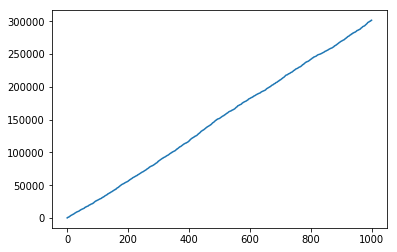

In [184]:
%matplotlib inline
from matplotlib import pyplot as plt

cum_regrets = list(regret)
for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]
    
plt.plot(cum_regrets)
# print(regret)

In [177]:
num_episodes=10000
batch_size=64
regret = []
eat = np.array([[1,0] for _ in range(batch_size)])
ignore = np.array([[0,1] for _ in range(batch_size)])

for i in range(num_episodes):
    
    # get 64 mushrooms
    idx = np.random.randint(len(data), size=batch_size)
    data_train = data[idx,:]
    X, poisonous = data_train[:,1:], data_train[:,0]
    
    
    
    # get scores for eating and ignoring
    eat_array = np.append(X, eat, axis=1)
    eat_scores = fnet(torch.tensor(eat_array).float().cuda())
    ignore_array = np.append(X, ignore, axis=1)
    ignore_scores = fnet(torch.tensor(ignore_array).float().cuda())
    
    x_train, y_train = np.zeros(eat_array.shape), np.zeros(poisonous.shape)
    
    # get training vectors
    diffs = (eat_scores.cpu().detach().numpy() - ignore_scores.cpu().detach().numpy()).reshape((batch_size,))
    x_train[diffs>0] = eat_array[diffs>0] # ate it
    x_train[diffs<=0] = ignore_array[diffs<=0] # ignored it
    
    # get training labels
    vals = np.random.normal(0, 1, batch_size)
    y_train[vals>0] = -35
    y_train[vals<=0] = 5
    y_train[poisonous==0] = 5 # ate it (safe)
    y_train[diffs <= 0] = 0 # if you ignored it

    
    # get regret for this episode
    oracle_score = 5 * sum(poisonous==1) # optimal strategy eats all good and ignores all bad
    agent_score = sum(y_train)
    regret.append(oracle_score - agent_score)
    
    # backprop
    outputs = eat_scores
    outputs[diffs<=0] = ignore_scores[diffs<=0]
    outputs = outputs.reshape((batch_size,))
    loss = criterion(torch.tensor(outputs).cuda(), torch.tensor(y_train).cuda())
    loss = Variable(loss, requires_grad = True)
    loss.backward()
    optimizer.step()
    
    print(i, oracle_score - agent_score)


 /homes/awl27/testenv/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 75.0
1 115.0
2 185.0
3 135.0
4 135.0
5 210.0
6 235.0
7 265.0
8 245.0
9 125.0
10 280.0
11 315.0
12 -5.0
13 180.0
14 210.0
15 245.0
16 340.0
17 145.0
18 335.0
19 110.0
20 475.0
21 155.0
22 180.0
23 245.0
24 185.0
25 275.0
26 190.0
27 225.0
28 160.0
29 190.0
30 180.0
31 100.0
32 200.0
33 115.0
34 125.0
35 180.0
36 255.0
37 150.0
38 355.0
39 160.0
40 215.0
41 190.0
42 125.0
43 140.0
44 105.0
45 60.0
46 250.0
47 215.0
48 105.0
49 165.0
50 155.0
51 50.0
52 235.0
53 130.0
54 190.0
55 205.0
56 105.0
57 265.0
58 230.0
59 350.0
60 70.0
61 295.0
62 260.0
63 285.0
64 215.0
65 225.0
66 250.0
67 125.0
68 140.0
69 205.0
70 155.0
71 140.0
72 160.0
73 300.0
74 95.0
75 150.0
76 245.0
77 195.0
78 205.0
79 360.0
80 230.0
81 295.0
82 245.0
83 220.0
84 250.0
85 105.0
86 210.0
87 335.0
88 265.0
89 70.0
90 215.0
91 405.0
92 280.0
93 95.0
94 100.0
95 105.0
96 110.0
97 245.0
98 365.0
99 265.0
100 185.0
101 145.0
102 170.0
103 230.0
104 335.0
105 175.0
106 130.0
107 65.0
108 160.0
109 145.0
110 195.0
111 170.0

874 135.0
875 215.0
876 90.0
877 360.0
878 215.0
879 335.0
880 230.0
881 215.0
882 305.0
883 330.0
884 165.0
885 125.0
886 270.0
887 205.0
888 385.0
889 250.0
890 190.0
891 235.0
892 180.0
893 210.0
894 255.0
895 195.0
896 100.0
897 315.0
898 225.0
899 205.0
900 135.0
901 205.0
902 205.0
903 240.0
904 55.0
905 235.0
906 165.0
907 250.0
908 400.0
909 455.0
910 365.0
911 205.0
912 270.0
913 215.0
914 40.0
915 70.0
916 110.0
917 185.0
918 100.0
919 200.0
920 190.0
921 490.0
922 215.0
923 220.0
924 175.0
925 85.0
926 135.0
927 255.0
928 215.0
929 235.0
930 150.0
931 175.0
932 185.0
933 230.0
934 355.0
935 120.0
936 205.0
937 265.0
938 455.0
939 260.0
940 140.0
941 255.0
942 225.0
943 215.0
944 235.0
945 180.0
946 150.0
947 140.0
948 410.0
949 145.0
950 185.0
951 65.0
952 25.0
953 225.0
954 200.0
955 235.0
956 120.0
957 235.0
958 150.0
959 195.0
960 175.0
961 65.0
962 35.0
963 295.0
964 55.0
965 310.0
966 65.0
967 215.0
968 190.0
969 125.0
970 150.0
971 190.0
972 210.0
973 150.0
974 250.0
9

1724 50.0
1725 240.0
1726 170.0
1727 155.0
1728 230.0
1729 270.0
1730 210.0
1731 165.0
1732 320.0
1733 240.0
1734 80.0
1735 290.0
1736 365.0
1737 250.0
1738 225.0
1739 105.0
1740 180.0
1741 300.0
1742 170.0
1743 80.0
1744 215.0
1745 120.0
1746 200.0
1747 200.0
1748 210.0
1749 195.0
1750 275.0
1751 185.0
1752 340.0
1753 355.0
1754 165.0
1755 315.0
1756 210.0
1757 100.0
1758 190.0
1759 405.0
1760 160.0
1761 75.0
1762 110.0
1763 105.0
1764 90.0
1765 70.0
1766 50.0
1767 210.0
1768 130.0
1769 155.0
1770 215.0
1771 230.0
1772 205.0
1773 210.0
1774 200.0
1775 65.0
1776 155.0
1777 120.0
1778 355.0
1779 150.0
1780 280.0
1781 155.0
1782 105.0
1783 165.0
1784 245.0
1785 230.0
1786 350.0
1787 155.0
1788 190.0
1789 195.0
1790 260.0
1791 215.0
1792 275.0
1793 185.0
1794 280.0
1795 140.0
1796 95.0
1797 145.0
1798 320.0
1799 250.0
1800 110.0
1801 105.0
1802 125.0
1803 250.0
1804 315.0
1805 145.0
1806 335.0
1807 185.0
1808 215.0
1809 265.0
1810 245.0
1811 170.0
1812 165.0
1813 265.0
1814 155.0
1815 155

2618 235.0
2619 70.0
2620 200.0
2621 170.0
2622 235.0
2623 170.0
2624 200.0
2625 260.0
2626 340.0
2627 160.0
2628 90.0
2629 160.0
2630 245.0
2631 195.0
2632 335.0
2633 155.0
2634 160.0
2635 135.0
2636 135.0
2637 405.0
2638 175.0
2639 140.0
2640 135.0
2641 195.0
2642 200.0
2643 270.0
2644 180.0
2645 220.0
2646 125.0
2647 280.0
2648 170.0
2649 260.0
2650 380.0
2651 130.0
2652 215.0
2653 220.0
2654 235.0
2655 145.0
2656 160.0
2657 310.0
2658 175.0
2659 265.0
2660 160.0
2661 480.0
2662 270.0
2663 190.0
2664 220.0
2665 230.0
2666 415.0
2667 230.0
2668 255.0
2669 210.0
2670 200.0
2671 180.0
2672 215.0
2673 295.0
2674 170.0
2675 210.0
2676 90.0
2677 395.0
2678 180.0
2679 305.0
2680 110.0
2681 150.0
2682 210.0
2683 320.0
2684 415.0
2685 165.0
2686 395.0
2687 260.0
2688 290.0
2689 330.0
2690 255.0
2691 125.0
2692 205.0
2693 210.0
2694 295.0
2695 285.0
2696 255.0
2697 85.0
2698 300.0
2699 230.0
2700 185.0
2701 180.0
2702 190.0
2703 50.0
2704 240.0
2705 245.0
2706 90.0
2707 165.0
2708 260.0
2709 

3519 190.0
3520 260.0
3521 230.0
3522 140.0
3523 270.0
3524 280.0
3525 195.0
3526 180.0
3527 70.0
3528 255.0
3529 100.0
3530 310.0
3531 105.0
3532 180.0
3533 135.0
3534 165.0
3535 250.0
3536 390.0
3537 25.0
3538 270.0
3539 110.0
3540 235.0
3541 85.0
3542 245.0
3543 115.0
3544 295.0
3545 165.0
3546 105.0
3547 205.0
3548 260.0
3549 230.0
3550 190.0
3551 170.0
3552 410.0
3553 295.0
3554 235.0
3555 150.0
3556 65.0
3557 140.0
3558 305.0
3559 225.0
3560 270.0
3561 165.0
3562 60.0
3563 130.0
3564 175.0
3565 285.0
3566 190.0
3567 70.0
3568 35.0
3569 130.0
3570 250.0
3571 200.0
3572 140.0
3573 110.0
3574 180.0
3575 130.0
3576 195.0
3577 130.0
3578 60.0
3579 230.0
3580 110.0
3581 225.0
3582 240.0
3583 135.0
3584 75.0
3585 260.0
3586 370.0
3587 255.0
3588 205.0
3589 105.0
3590 160.0
3591 295.0
3592 250.0
3593 35.0
3594 110.0
3595 110.0
3596 205.0
3597 250.0
3598 205.0
3599 220.0
3600 70.0
3601 70.0
3602 225.0
3603 185.0
3604 155.0
3605 155.0
3606 300.0
3607 115.0
3608 105.0
3609 255.0
3610 240.0


4390 170.0
4391 70.0
4392 365.0
4393 375.0
4394 210.0
4395 185.0
4396 130.0
4397 225.0
4398 140.0
4399 140.0
4400 185.0
4401 245.0
4402 245.0
4403 75.0
4404 250.0
4405 215.0
4406 260.0
4407 320.0
4408 135.0
4409 280.0
4410 125.0
4411 50.0
4412 170.0
4413 265.0
4414 215.0
4415 195.0
4416 150.0
4417 180.0
4418 115.0
4419 125.0
4420 150.0
4421 145.0
4422 120.0
4423 200.0
4424 30.0
4425 70.0
4426 220.0
4427 75.0
4428 480.0
4429 150.0
4430 300.0
4431 320.0
4432 145.0
4433 150.0
4434 175.0
4435 235.0
4436 235.0
4437 215.0
4438 200.0
4439 70.0
4440 105.0
4441 145.0
4442 300.0
4443 175.0
4444 115.0
4445 235.0
4446 160.0
4447 205.0
4448 330.0
4449 190.0
4450 75.0
4451 300.0
4452 60.0
4453 120.0
4454 180.0
4455 225.0
4456 135.0
4457 150.0
4458 170.0
4459 105.0
4460 90.0
4461 160.0
4462 175.0
4463 265.0
4464 200.0
4465 375.0
4466 155.0
4467 55.0
4468 200.0
4469 155.0
4470 105.0
4471 150.0
4472 175.0
4473 265.0
4474 175.0
4475 155.0
4476 195.0
4477 145.0
4478 90.0
4479 205.0
4480 250.0
4481 305.0


5281 45.0
5282 255.0
5283 305.0
5284 125.0
5285 220.0
5286 270.0
5287 155.0
5288 150.0
5289 225.0
5290 215.0
5291 130.0
5292 140.0
5293 90.0
5294 10.0
5295 130.0
5296 95.0
5297 245.0
5298 390.0
5299 250.0
5300 175.0
5301 370.0
5302 310.0
5303 250.0
5304 120.0
5305 290.0
5306 290.0
5307 135.0
5308 180.0
5309 205.0
5310 105.0
5311 155.0
5312 210.0
5313 200.0
5314 175.0
5315 65.0
5316 235.0
5317 45.0
5318 145.0
5319 105.0
5320 235.0
5321 160.0
5322 150.0
5323 145.0
5324 255.0
5325 235.0
5326 155.0
5327 195.0
5328 265.0
5329 220.0
5330 355.0
5331 295.0
5332 80.0
5333 125.0
5334 150.0
5335 190.0
5336 165.0
5337 155.0
5338 215.0
5339 180.0
5340 260.0
5341 330.0
5342 255.0
5343 305.0
5344 225.0
5345 225.0
5346 260.0
5347 280.0
5348 30.0
5349 350.0
5350 205.0
5351 245.0
5352 175.0
5353 45.0
5354 70.0
5355 245.0
5356 125.0
5357 290.0
5358 215.0
5359 255.0
5360 285.0
5361 330.0
5362 220.0
5363 255.0
5364 165.0
5365 195.0
5366 155.0
5367 230.0
5368 230.0
5369 185.0
5370 220.0
5371 105.0
5372 270.

6148 220.0
6149 115.0
6150 110.0
6151 190.0
6152 25.0
6153 80.0
6154 320.0
6155 150.0
6156 200.0
6157 95.0
6158 200.0
6159 270.0
6160 180.0
6161 345.0
6162 175.0
6163 145.0
6164 420.0
6165 135.0
6166 40.0
6167 190.0
6168 315.0
6169 215.0
6170 45.0
6171 175.0
6172 180.0
6173 355.0
6174 245.0
6175 390.0
6176 210.0
6177 135.0
6178 265.0
6179 250.0
6180 100.0
6181 100.0
6182 120.0
6183 130.0
6184 220.0
6185 255.0
6186 185.0
6187 195.0
6188 225.0
6189 145.0
6190 265.0
6191 235.0
6192 365.0
6193 200.0
6194 295.0
6195 195.0
6196 120.0
6197 90.0
6198 165.0
6199 175.0
6200 70.0
6201 360.0
6202 90.0
6203 365.0
6204 225.0
6205 140.0
6206 230.0
6207 95.0
6208 65.0
6209 145.0
6210 45.0
6211 115.0
6212 305.0
6213 95.0
6214 195.0
6215 120.0
6216 5.0
6217 135.0
6218 280.0
6219 200.0
6220 250.0
6221 100.0
6222 250.0
6223 65.0
6224 300.0
6225 100.0
6226 315.0
6227 265.0
6228 225.0
6229 110.0
6230 145.0
6231 190.0
6232 255.0
6233 135.0
6234 90.0
6235 50.0
6236 140.0
6237 95.0
6238 70.0
6239 290.0
6240 28

6907 230.0
6908 135.0
6909 155.0
6910 155.0
6911 160.0
6912 235.0
6913 170.0
6914 280.0
6915 430.0
6916 160.0
6917 215.0
6918 225.0
6919 380.0
6920 320.0
6921 200.0
6922 125.0
6923 160.0
6924 215.0
6925 200.0
6926 215.0
6927 370.0
6928 100.0
6929 140.0
6930 65.0
6931 420.0
6932 260.0
6933 250.0
6934 270.0
6935 205.0
6936 175.0
6937 230.0
6938 125.0
6939 215.0
6940 165.0
6941 230.0
6942 390.0
6943 300.0
6944 55.0
6945 280.0
6946 215.0
6947 375.0
6948 260.0
6949 225.0
6950 135.0
6951 155.0
6952 115.0
6953 105.0
6954 65.0
6955 145.0
6956 205.0
6957 100.0
6958 230.0
6959 -10.0
6960 275.0
6961 345.0
6962 300.0
6963 235.0
6964 395.0
6965 150.0
6966 160.0
6967 70.0
6968 110.0
6969 80.0
6970 180.0
6971 150.0
6972 105.0
6973 270.0
6974 125.0
6975 45.0
6976 110.0
6977 150.0
6978 175.0
6979 65.0
6980 195.0
6981 140.0
6982 170.0
6983 95.0
6984 280.0
6985 260.0
6986 75.0
6987 180.0
6988 225.0
6989 135.0
6990 245.0
6991 260.0
6992 210.0
6993 225.0
6994 200.0
6995 25.0
6996 175.0
6997 200.0
6998 160.

7690 40.0
7691 150.0
7692 275.0
7693 140.0
7694 165.0
7695 190.0
7696 180.0
7697 170.0
7698 140.0
7699 235.0
7700 175.0
7701 205.0
7702 120.0
7703 325.0
7704 320.0
7705 90.0
7706 290.0
7707 280.0
7708 135.0
7709 280.0
7710 105.0
7711 70.0
7712 175.0
7713 310.0
7714 245.0
7715 350.0
7716 310.0
7717 265.0
7718 180.0
7719 300.0
7720 185.0
7721 225.0
7722 180.0
7723 235.0
7724 110.0
7725 365.0
7726 275.0
7727 120.0
7728 205.0
7729 100.0
7730 180.0
7731 220.0
7732 20.0
7733 160.0
7734 305.0
7735 50.0
7736 300.0
7737 210.0
7738 315.0
7739 200.0
7740 230.0
7741 165.0
7742 190.0
7743 350.0
7744 240.0
7745 250.0
7746 250.0
7747 85.0
7748 160.0
7749 80.0
7750 125.0
7751 60.0
7752 285.0
7753 150.0
7754 165.0
7755 175.0
7756 290.0
7757 265.0
7758 230.0
7759 215.0
7760 245.0
7761 260.0
7762 205.0
7763 85.0
7764 345.0
7765 375.0
7766 115.0
7767 215.0
7768 100.0
7769 165.0
7770 180.0
7771 180.0
7772 325.0
7773 205.0
7774 250.0
7775 130.0
7776 195.0
7777 190.0
7778 185.0
7779 90.0
7780 35.0
7781 315.0

8585 170.0
8586 365.0
8587 190.0
8588 90.0
8589 70.0
8590 115.0
8591 80.0
8592 90.0
8593 170.0
8594 250.0
8595 175.0
8596 270.0
8597 205.0
8598 65.0
8599 255.0
8600 170.0
8601 260.0
8602 220.0
8603 305.0
8604 315.0
8605 40.0
8606 110.0
8607 370.0
8608 230.0
8609 80.0
8610 135.0
8611 305.0
8612 280.0
8613 240.0
8614 250.0
8615 145.0
8616 60.0
8617 155.0
8618 175.0
8619 205.0
8620 85.0
8621 475.0
8622 215.0
8623 305.0
8624 120.0
8625 155.0
8626 140.0
8627 175.0
8628 265.0
8629 285.0
8630 180.0
8631 135.0
8632 160.0
8633 160.0
8634 155.0
8635 145.0
8636 185.0
8637 275.0
8638 130.0
8639 355.0
8640 130.0
8641 230.0
8642 320.0
8643 215.0
8644 230.0
8645 140.0
8646 180.0
8647 220.0
8648 295.0
8649 335.0
8650 260.0
8651 190.0
8652 130.0
8653 5.0
8654 35.0
8655 160.0
8656 50.0
8657 130.0
8658 220.0
8659 55.0
8660 130.0
8661 145.0
8662 20.0
8663 65.0
8664 220.0
8665 195.0
8666 190.0
8667 265.0
8668 330.0
8669 145.0
8670 200.0
8671 210.0
8672 330.0
8673 115.0
8674 240.0
8675 200.0
8676 155.0
8677

9480 235.0
9481 275.0
9482 55.0
9483 290.0
9484 115.0
9485 225.0
9486 170.0
9487 30.0
9488 215.0
9489 250.0
9490 330.0
9491 420.0
9492 360.0
9493 290.0
9494 140.0
9495 230.0
9496 205.0
9497 210.0
9498 285.0
9499 200.0
9500 260.0
9501 100.0
9502 355.0
9503 190.0
9504 170.0
9505 345.0
9506 175.0
9507 290.0
9508 115.0
9509 160.0
9510 90.0
9511 200.0
9512 175.0
9513 85.0
9514 340.0
9515 225.0
9516 265.0
9517 280.0
9518 60.0
9519 100.0
9520 205.0
9521 280.0
9522 310.0
9523 35.0
9524 165.0
9525 265.0
9526 320.0
9527 365.0
9528 225.0
9529 265.0
9530 105.0
9531 55.0
9532 135.0
9533 270.0
9534 165.0
9535 255.0
9536 125.0
9537 355.0
9538 200.0
9539 215.0
9540 185.0
9541 155.0
9542 325.0
9543 295.0
9544 320.0
9545 550.0
9546 210.0
9547 5.0
9548 215.0
9549 230.0
9550 265.0
9551 85.0
9552 260.0
9553 140.0
9554 150.0
9555 200.0
9556 175.0
9557 195.0
9558 195.0
9559 205.0
9560 275.0
9561 125.0
9562 250.0
9563 140.0
9564 75.0
9565 245.0
9566 180.0
9567 310.0
9568 275.0
9569 195.0
9570 230.0
9571 45.0


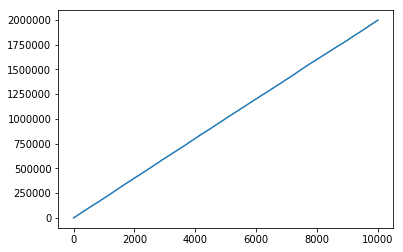

In [178]:
%matplotlib inline
from matplotlib import pyplot as plt

cum_regrets = list(regret)
for i in range(1, len(cum_regrets)): cum_regrets[i] += cum_regrets[i-1]
    
plt.plot(cum_regrets)
# print(regret)